In [2]:
import warnings
warnings.filterwarnings("ignore")
import xml.etree.ElementTree as et 
import os
import pandas as pd
import re
from collections import Counter
import numpy as np
import gensim
from tqdm import tqdm
from sklearn.metrics import pairwise_distances
import time
import random
import joblib
from sklearn.preprocessing import OneHotEncoder
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import *
from bs4 import BeautifulSoup
from datetime import datetime
import matplotlib.pyplot as plt
from IPython.display import HTML, display, Markdown, clear_output
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from ipywidgets import widgets

In [3]:
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

###  Exploratory Data Analysis

#### Parsing XML files and converting to pandas dataframe

In [4]:
def parse_XML(xml_file, df_cols): 
    """
    Parse the input XML file and store the result in a pandas  DataFrame with the given columns. 
    
    The first element of df_cols is supposed to be the identifier  variable, which is an attribute of each
    node element in the  XML data; other features will be parsed from the text content of each sub-element. 
    """
    #Parse XML document into element tree.
    xtree = et.parse(xml_file) #Returns ElementTree instance.
    xroot = xtree.getroot()
    rows = []
    
    for node in xroot:
        res = []
        for i in range(len(df_cols)):
            res.append(node.attrib.get(df_cols[i]))
        rows.append({df_cols[i]: res[i] for i, _ in enumerate(df_cols)})
        
    out_df = pd.DataFrame(rows, columns=df_cols)

    out_df["Id"] = range(out_df.shape[0])
    # out_df["Topic"] = xml_file.split("/")[1].split('.')[0]
    out_df["Topic"] = 'Security'
    out_df.set_index("Id", inplace = False) 

    return out_df

### Post data

In [5]:
# allfiles = ["Data/"+i+"/Posts.xml" for i in os.listdir("Data")]

allfiles = ['C://Users//yun//Desktop//rs//Code//securitySO//Posts.xml']
merged_df = pd.DataFrame(columns=['Id', 'Body', 'Title', 'Tags', 'Topic',])
merged_df.set_index("Id", inplace = False) 
for fileloc in allfiles:
    temp = parse_XML(fileloc, ['Id', 'Body', 'Title', 'Tags', 'Topic'])
    merged_df = pd.concat([merged_df,temp])

print(merged_df.shape)
merged_df.head()

(160899, 5)


,Id,Body,Title,Tags,Topic
0,0,"<p>This semester, I'm offering a course on ""se...","Courses on ""Secure Software Development""",<academia><professional-education>,Security
1,1,"<p>I've started using Ruby on Rails, and I was...",Rails - protection against code injection and XSS,<appsec><attack-prevention><source-code><xss><...,Security
2,2,"<p>I haven't taken the course, but I've heard ...",None,None,Security
3,3,<p>From the view of somebody offering a web ap...,Does an established HTTPS connection mean a li...,<web-application><tls>,Security
4,4,<p>In a web application there could be two app...,"Is filtering of user input data enough, or sho...",<web-application><xss><appsec><attack-prevention>,Security


### User data

In [29]:
# allfiles = ["Data/"+i+"/Posts.xml" for i in os.listdir("Data")]

allfiles = ['C://Users//yun//Desktop//rs//Code//securitySO//Users.xml']
user_merged_df = pd.DataFrame(columns=['Id', 'Tags', 'Topic','AboutMe'])
user_merged_df.set_index("Id", inplace = False) 
for fileloc in allfiles:
    temp = parse_XML(fileloc, ['Id', 'Body', 'Title', 'Tags', 'Topic','AboutMe'])
    user_merged_df = pd.concat([user_merged_df,temp])

print(user_merged_df.shape)
user_merged_df.head()


(184700, 6)


,AboutMe,Body,Id,Tags,Title,Topic
0,"<p>Hi, I'm not really a person.</p>\n\n<p>I'm ...",None,0,None,None,Security
1,<p>Developer on the Stack Overflow team. Find...,None,1,None,None,Security
2,None,None,2,None,None,Security
3,<p></p>\n,None,3,None,None,Security
4,None,None,4,None,None,Security


In [13]:
user_merged_df

NameError: name 'user_merged_df' is not defined

user_list

In [30]:
user_id = merged_df['Id']
user_list = np.array(user_id)
np.save('user_list.npy',user_list)
with open('user_list.txt','w') as f:
    for i in range(len(user_id)):
        f.write(str(user_list[i])+' '+str(i)+'\n')

#### Basic Statistics and analysis

In [6]:
merged_df.describe()

,Id,Body,Title,Tags,Topic
count,160899,160899,56880,56880,160899
unique,160899,160372,56865,34815,1
top,160898,,Google App Engine Security,<tls>,Security
freq,1,512,2,458,160899


Observation:
* There are total of 650561 datapoints.
* Out of which 647727 datapoints are unique.
* But as we can observe, most of the title of body is not available. There are 243391 datapoint with Title with duplicate result.
* There are total 242988 datapoints with unoque title.

In [5]:
title_desc = merged_df['Title'].describe()
title_desc

count                                            56880
unique                                           56865
top       How often should an SSH key pair be changed?
freq                                                 2
Name: Title, dtype: object

In [8]:
print('Total number of Title: ',merged_df.shape[0])
print('\nTotal number of not null Title: ',title_desc['count'])
print('\nTotal number of unique Title: ',title_desc['unique'])
print('\nTotal number of duplicate Title: ',title_desc['count'] - title_desc['unique'])

Total number of Title:  160899

Total number of not null Title:  56880

Total number of unique Title:  56865

Total number of duplicate Title:  15


In [6]:
#Computing total number of unique word in title column
# title = merged_df['preprocessed_title'].values
title = merged_df['Title'].values
total_title = ""
for i in title:
    if i != None:
        total_title += i+' '
lst_title = total_title.split()
vocab_title = list(set(lst_title))
print('Total number of unique word(vocab) in title column is: ',len(vocab_title))

Total number of unique word(vocab) in title column is:  44480


In [6]:
#Computing count for each word in title
title_word_dict = dict()
for i in vocab_title:
    title_word_dict[i] = 0
for i in lst_title:
    title_word_dict[i] += 1

title_word_count_df = pd.DataFrame(title_word_dict.items(), columns=['Word', 'Count'])
title_word_count_sorted_df = title_word_count_df.sort_values(by=['Count'],ascending=True)

title_word_count_df.head()

NameError: name 'vocab_title' is not defined

In [11]:
#Getting top 10 word which are very rare
print('Top 10 word which are very rare are as follows:')
title_word_count_sorted_df.head(10)

Top 10 word which are very rare are as follows:


,Word,Count
0,turing,1
26151,intelligence)?,1
26150,undetected,1
26147,amount?,1
26146,sites/forums?,1
26143,Michael,1
26140,cacheable?,1
26138,their's,1
26136,compromisation,1
26135,"repositories""?",1


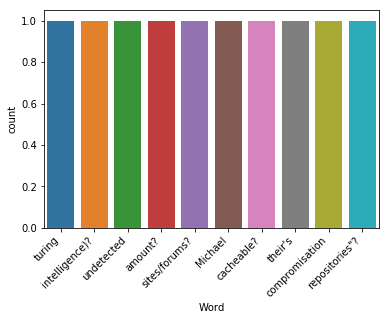

In [12]:
#Countplot with top 10 rare word
ax = sns.countplot(x ='Word', data = title_word_count_sorted_df.head(10))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

In [13]:
#Getting top 10 word which has most occured
print('Top 10 word which are very most occured are as follows:')
title_word_count_sorted_df.tail(10)

Top 10 word which are very most occured are as follows:


,Word,Count
40147,Is,5870
23153,is,6303
41953,for,6483
19592,and,6555
40227,of,7669
30382,in,7848
19661,How,9072
9624,the,11279
12941,a,15942
36547,to,17231


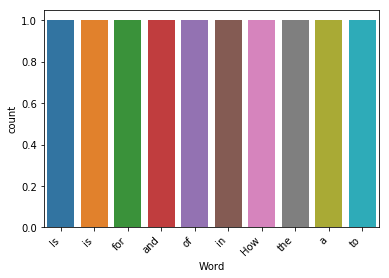

In [14]:
#Countplot with top 10 most occured word
ax = sns.countplot(x ='Word', data = title_word_count_sorted_df.tail(10))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

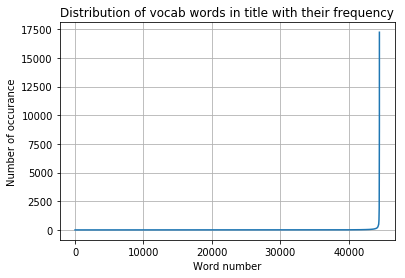

In [15]:
plt.plot(title_word_count_sorted_df['Count'].values)
plt.title('Distribution of vocab words in title with their frequency')
plt.grid()
plt.xlabel('Word number')
plt.ylabel('Number of occurance')
plt.show()

Observation:
* Above graph shows distribution of all unique each word with its count in title data corpus.
* As we can observe, almost 60k unique words in title has occured very less whereas other 3k words has occured more.

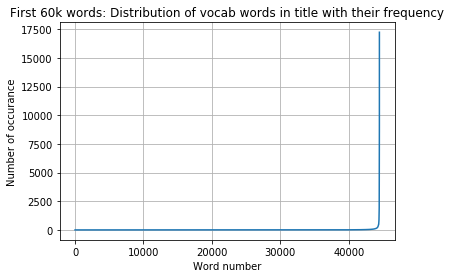

In [34]:
plt.plot(title_word_count_sorted_df['Count'].values[:60000])
plt.title('First 60k words: Distribution of vocab words in title with their frequency')
plt.grid()
plt.xlabel('Word number')
plt.ylabel('Number of occurance')
plt.show()

Observation:
* Above graph shows distribution of first 60k word with its count in title data corpus.
* As we can observe, almost 36-37k words has occured only once.

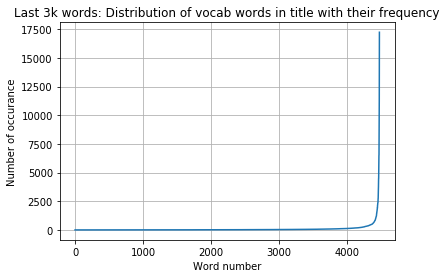

In [37]:
plt.plot(title_word_count_sorted_df['Count'].values[40000:])
plt.title('Last 3k words: Distribution of vocab words in title with their frequency')
plt.grid()
plt.xlabel('Word number')
plt.ylabel('Number of occurance')
plt.show()

Observation:
* Above graph shows distribution of last 3k+ word with its count in title data corpus.
* As we can observe, last 200+ words has highest frequency.

In [8]:
#Finding actual count of rare and most occured words and their percentage in total title data corpus.
rare_count,most_count = 0,0
for i in range(title_word_count_sorted_df.shape[0]):
    if title_word_count_sorted_df['Count'].values[i] < 3:
        rare_count += 1
    if title_word_count_sorted_df['Count'].values[i] > 100:
        most_count += 1

print('Total number of rare words(occured less than 3 times) are:',rare_count)
print(str((rare_count * 100)/title_word_count_sorted_df.shape[0])[:5],'% of words in total title data is rare.')

print('\nTotal number of most occured words(occured more than 100 times) are:',most_count)
print(str((most_count * 100)/title_word_count_sorted_df.shape[0])[:5],'% of words in total title data has most occured.')

Total number of rare words(occured less than 3 times) are: 32746
73.61 % of words in total title data is rare.

Total number of most occured words(occured more than 100 times) are: 654
1.470 % of words in total title data has most occured.


In [7]:
#all tags in a list
tags = list(merged_df['Tags'].values)

In [8]:
#getting all individual tag in a list
all_tags = tags[0]
for i in range(len(tags) - 1):
    if tags[i+1] != None:
        all_tags += tags[i+1]

In [9]:
all_tags = pd.DataFrame([i + '>'for i in all_tags.split('>')[:-2]])
'''

Changed from <deep-network><search><neurons>
to <deep-network>
   <search>
   <neurons>

'''

'\n\nChanged from <deep-network><search><neurons>\nto <deep-network>\n   <search>\n   <neurons>\n\n'

In [20]:
all_tags.head()

,0
0,<academia>
1,<professional-education>
2,<appsec>
3,<attack-prevention>
4,<source-code>


In [21]:
tag_desc = all_tags.describe()
tag_desc

,0
count,150493
unique,1201
top,<encryption>
freq,4998


In [48]:
print('Total number of Tags: ',tag_desc[0]['count'])
print('\nTotal number of unique Tags: ',tag_desc[0]['unique'])
print('\nTag {0} has highest frequency of {1}.'.format(tag_desc[0]['top'],tag_desc[0]['freq']))

Total number of Tags:  150493

Total number of unique Tags:  1201

Tag <encryption> has highest frequency of 4998.


In [10]:
tag_dict = dict()
for i in set(all_tags[0].values):
    tag_dict[i] = 0
for i in all_tags[0].values:
    tag_dict[i] += 1

tag_count_df = pd.DataFrame(tag_dict.items(), columns=['Tag', 'Count'])
tag_count_df.head()

,Tag,Count
0,<skimming>,2
1,<hsm>,102
2,<asp.net-core>,22
3,<sdlc>,5
4,<opensource>,143


In [57]:
len(tag_count_df['Count'].values)

1201

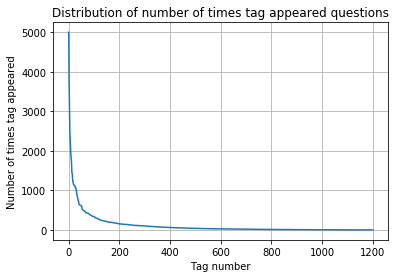

In [58]:
plt.plot(sorted(tag_count_df['Count'].values,reverse=True))
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

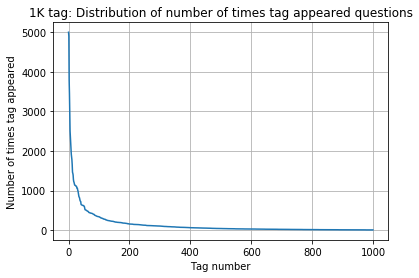

In [59]:
plt.plot(sorted(tag_count_df['Count'].values,reverse=True)[:1000])
plt.title("1K tag: Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

Observation:
* More than 200 tags are used more than 1000 time.
* Out of which 20 to 25 tags are used more than 4000 times.

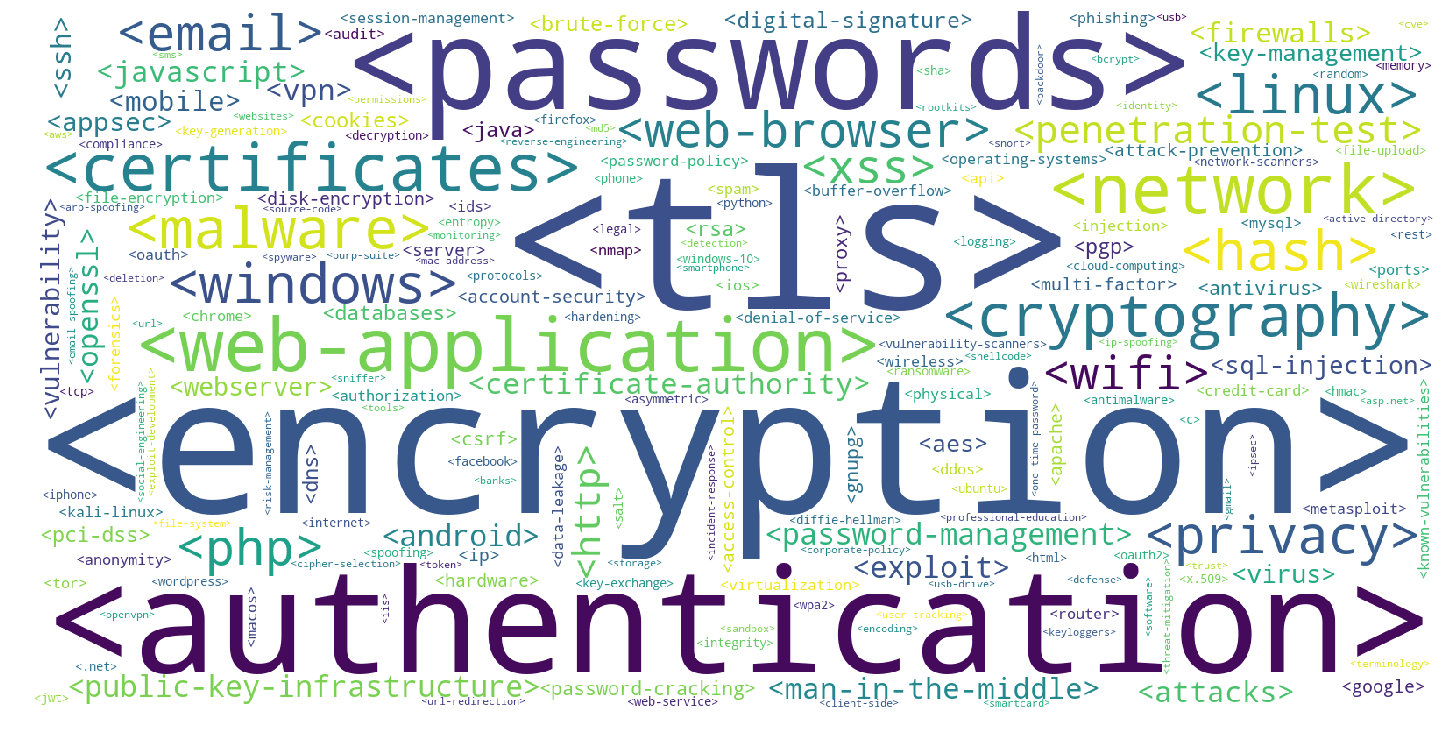

In [61]:
# Ploting word cloud

tup = dict(tag_dict.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='white',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(20,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [62]:
topic_desc = merged_df['Topic'].describe()
topic_desc

count       160899
unique           1
top       Security
freq        160899
Name: Topic, dtype: object

In [ ]:
print('Total number of unique Topics: ',topic_desc['unique'])
print('\nUnique topics are: ',merged_df['Topic'].unique())
print('\nTopic {0} has the highest frequency of {1}.'.format(topic_desc['top'],topic_desc['freq']))

Total number of unique Topics:  10

Unique topics are:  ['ai' 'arduino' 'computergraphics' 'cs' 'android' 'robotics' 'webapps'
 'datascience' 'iot' 'softwareengineering']

Topic softwareengineering has the highest frequency of 59026.


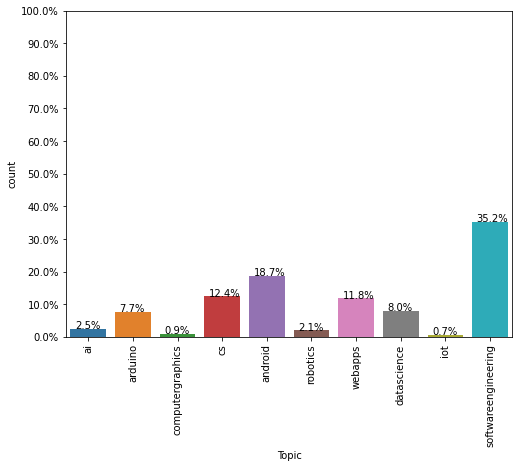

In [ ]:
plt.figure(figsize=(8,6))

total = len(merged_df['Topic'].values) + 1
ax = sns.countplot(x="Topic", data=merged_df)

for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

#put 11 ticks (therefore 10 steps), from 0 to the total number of rows in the dataframe
ax.yaxis.set_ticks(np.linspace(0, total, 11))

#adjust the ticklabel to the desired format, without changing the position of the ticks. 
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.show()


Observation:
* The above graph shows the topic wise distribution of question.
* As we can observe, 35.2% of questions are from softwareengineering topic which is the maximum.
* Where as topic IoT has least number of question which is of 0.7%.

In [11]:
#Computing total number of unique word in body column
# text = merged_df['preprocessed_text'].values
text = merged_df['Body'].values
total_text = ""
for i in text:
    total_text += i
lst_text = total_text.split()
vocab_text = list(set(lst_text))
print('Total number of unique word(vocab) in question body column is: ',len(vocab_text))

Total number of unique word(vocab) in question body column is:  1096223


In [14]:
#Computing count for each word in text
text_word_dict = dict()
for i in vocab_text:
    text_word_dict[i] = 0
for i in lst_text:
    text_word_dict[i] += 1

text_word_count_df = pd.DataFrame(text_word_dict.items(), columns=['Word', 'Count'])
text_word_count_sorted_df = text_word_count_df.sort_values(by=['Count'],ascending=True)

text_word_count_df.head()

,Word,Count
0,|B,1
1,"href=""http://beyondtechs.blogspot.com/2012/09/...",1
2,"href=""https://en.wikipedia.org/wiki/Card_secur...",2
3,"Dazzle,",1
4,"Gospel,",1


In [25]:
#Getting top 10 word which are very rare
print('Top 10 word which are very rare are as follows:')
text_word_count_sorted_df.head(10)

Top 10 word which are very rare are as follows:


,Word,Count
548111,"holds""?",1
528757,wariness,1
902371,<code>modsecurity_crs_40_generic_attacks.conf<...,1
528759,<em>sequence</em>:,1
528760,"""%W¤GHAF034jio43Q¤#%q3æPÅJ(%""",1
528761,"""baited",1
528762,“puzzles”,1
528763,victimId='1.1.1.1',1
528764,properly?</p></li>,1
528765,<code>C:P/I:P/A:P</code>.,1


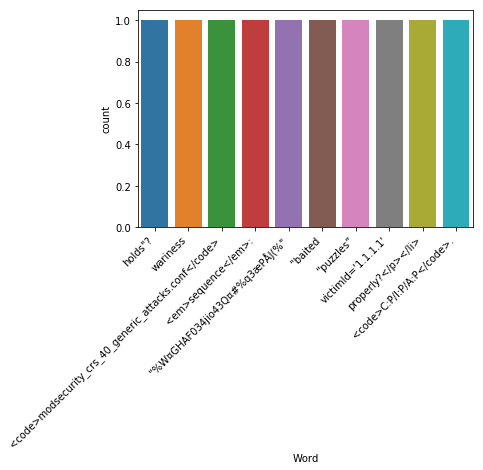

In [26]:
#Countplot with top 10 rare word
ax = sns.countplot(x ='Word', data = text_word_count_sorted_df.head(10))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

In [27]:
#Getting top 10 word which has most occured
print('Top 10 word which are very most occured are as follows:')
text_word_count_sorted_df.tail(10)

Top 10 word which are very most occured are as follows:


,Word,Count
71535,be,243956
251815,in,287843
504599,you,302962
812025,that,348608
198457,of,434845
578823,and,457865
377684,is,493432
568585,a,649641
1083830,to,824258
494705,the,1237605


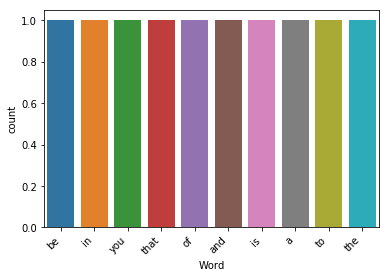

In [28]:
#Countplot with top 10 most occured word
ax = sns.countplot(x ='Word', data = text_word_count_sorted_df.tail(10))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

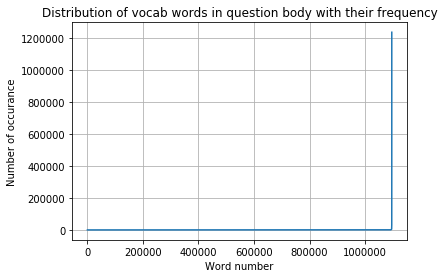

In [29]:
plt.plot(text_word_count_sorted_df['Count'].values)
plt.title('Distribution of vocab words in question body with their frequency')
plt.grid()
plt.xlabel('Word number')
plt.ylabel('Number of occurance')
plt.show()

Observation:
* Above graph shows distribution of all unique each word with its count in question body data corpus.
* As we can observe, almost 850k+ unique words in title has occured very rarely.

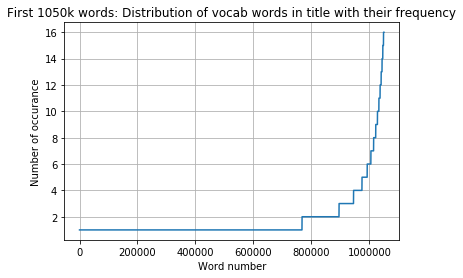

In [30]:
plt.plot(text_word_count_sorted_df['Count'].values[:1050000])
plt.title('First 1050k words: Distribution of vocab words in title with their frequency')
plt.grid()
plt.xlabel('Word number')
plt.ylabel('Number of occurance')
plt.show()

Observation:
* Above graph shows distribution of first 850k word with its count in question body data corpus.
* As we can observe, almost more than 600k words has occured only once.

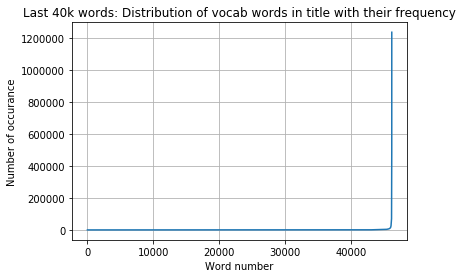

In [31]:
plt.plot(text_word_count_sorted_df['Count'].values[1050000:])
plt.title('Last 40k words: Distribution of vocab words in title with their frequency')
plt.grid()
plt.xlabel('Word number')
plt.ylabel('Number of occurance')
plt.show()

Observation:
* Above graph shows distribution of last 40k+ word with its count in question body data corpus.
* As we can observe, last 5k+ words has highest frequency.

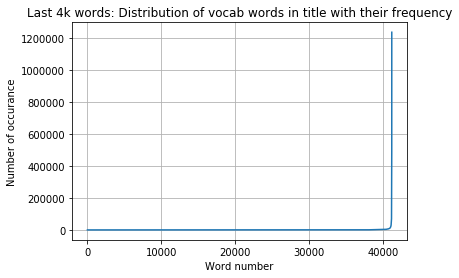

In [32]:
plt.plot(text_word_count_sorted_df['Count'].values[1055000:])
plt.title('Last 4k words: Distribution of vocab words in title with their frequency')
plt.grid()
plt.xlabel('Word number')
plt.ylabel('Number of occurance')
plt.show()

Observation:
* Above graph shows distribution of last 4k+ word with its count in question body data corpus.
* As we can observe, last 500+ words has occured more than 10k times.

In [15]:
#Finding actual count of rare and most occured words and their percentage in total question body data corpus.
rare_count,most_count = 0,0
for i in range(text_word_count_sorted_df.shape[0]):
    if text_word_count_sorted_df['Count'].values[i] < 3:
        rare_count += 1
    if text_word_count_sorted_df['Count'].values[i] > 100:
        most_count += 1

print('Total number of rare words(occured less than 3 times) are:',rare_count)
print(str((rare_count * 100)/text_word_count_sorted_df.shape[0])[:5],'% of words in total question body data is rare.')

print('\nTotal number of most occured words(occured more than 100 times) are:',most_count)
print(str((most_count * 100)/text_word_count_sorted_df.shape[0])[:5],'% of words in total question body data has most occured.')

Total number of rare words(occured less than 3 times) are: 895099
81.65 % of words in total question body data is rare.

Total number of most occured words(occured more than 100 times) are: 12884
1.175 % of words in total question body data has most occured.


In [16]:
df_cols = ['Id','Body', 'Title', 'Tags', 'Topic']
lower_title = []

for i in df_cols:
    merged_df = merged_df[~merged_df[i].isna()]
    merged_df = merged_df[~merged_df[i].isnull()]
merged_df = merged_df.drop_duplicates(subset="Title")

merged_df.shape

(56865, 5)

In [17]:
merged_df.head(5)

,Id,Body,Title,Tags,Topic
0,0,"<p>This semester, I'm offering a course on ""se...","Courses on ""Secure Software Development""",<academia><professional-education>,Security
1,1,"<p>I've started using Ruby on Rails, and I was...",Rails - protection against code injection and XSS,<appsec><attack-prevention><source-code><xss><...,Security
3,3,<p>From the view of somebody offering a web ap...,Does an established HTTPS connection mean a li...,<web-application><tls>,Security
4,4,<p>In a web application there could be two app...,"Is filtering of user input data enough, or sho...",<web-application><xss><appsec><attack-prevention>,Security
6,6,<p>I have a PHP application that I would like ...,How to perform a security audit for a PHP appl...,<appsec><php><penetration-test><code-review>,Security


In [18]:
#Getting all values in a list
text = list(merged_df['Body'].values)
title = list(merged_df['Title'].values)

In [19]:
#Ref: https://github.com/gayathriabhi/StackOverflow-Search-Engine/blob/master/Search_engine.ipynb

def remove_html(sentence):
    '''
    This function is to clean the word of any html-tags and make it lower Cases
    It accepts sentence or word as parameter and returns lower and removed html tag sentence or word
    '''
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext.lower()

def remove_url(sentence):
    '''
    This function is to remove url from the text
    '''
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+';
    return re.sub(url_regex, '', sentence);

def remove_punctuation(sentence):
    '''
    This function is to clean the word of any punctuation or special characters
    '''
    cleaned = re.sub(r'[?|!|"|#|:|=|+|_|{|}|[|]|-|$|%|^|&|]',r' ',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/|-|~|`|>|<|*|$|@|;|→]',r' ',cleaned)
    return cleaned

def decontraction(sentence):
    '''
    This is to decontraction of a text
    e.g. won't to will not
    '''
    # specific phrases
    sentence = re.sub(r"won't", "will not", sentence)
    sentence = re.sub(r"can\'t", "can not", sentence)
    # general phrases
    sentence = re.sub(r"n\'t", " not", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'s", " is", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'t", " not", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'m", " am", sentence)
    sentence = re.sub(r"\n", " ", sentence)
    sentence = re.sub(r"\t", " ", sentence)
    return sentence

def remove_stopwords(total_text):
    '''
    This function is to remove the english stopwords from text data
    '''
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
            word = ("".join(e for e in words if e.isalnum()))
            # stop-word removal
            if not word in stop_words:
                string += word + " "
        return string

In [20]:
#Calling above functions to clean Title and Body feature

preprocessed_text, preprocessed_title = [], []

for i in text:
    preprocessed_text.append(remove_stopwords(decontraction(remove_punctuation(remove_url(remove_html(i))))))

for i in title:
    preprocessed_title.append(remove_stopwords(decontraction(remove_punctuation(remove_url(remove_html(i))))))

In [38]:
#Removing angular braces from tags and separting them by space and replacing '-' with '_'

preprocessed_tags = []
tags = list(merged_df['Tags'].values)
for tag in tags:
    #Removing angulay braces and separating them by space
    tag = str(tag)
    c = re.sub(r'><',r' ',tag) 
    c = re.sub(r'<|>',r'',c)
    #Replacing '-' with '_'
    c = re.sub(r'-',r'_',c)
    preprocessed_tags.append(c)

Item_list

In [28]:
post_id = merged_df['Id']
post_id = np.array(post_id)
item_t = []

for i in range(len(post_id)):
    item_t.append([post_id[i],i,'Id'+str(i)])

np.save('Item_list1.npy',item_t)

with open('Item_list1.txt','w') as f:
    for i in range(len(post_id)):
        f.write(str(post_id[i])+' '+str(i)+' '+'Id'+str(i)+ '\n')

In [25]:
merged_df.head()

,Id,Body,Title,Tags,Topic
0,0,"<p>This semester, I'm offering a course on ""se...","Courses on ""Secure Software Development""",<academia><professional-education>,Security
1,1,"<p>I've started using Ruby on Rails, and I was...",Rails - protection against code injection and XSS,<appsec><attack-prevention><source-code><xss><...,Security
3,3,<p>From the view of somebody offering a web ap...,Does an established HTTPS connection mean a li...,<web-application><tls>,Security
4,4,<p>In a web application there could be two app...,"Is filtering of user input data enough, or sho...",<web-application><xss><appsec><attack-prevention>,Security
6,6,<p>I have a PHP application that I would like ...,How to perform a security audit for a PHP appl...,<appsec><php><penetration-test><code-review>,Security


In [39]:
print(merged_df.shape)
print(len(preprocessed_tags))

(56865, 5)
56865


In [40]:
merged_df['preprocessed_title'] = preprocessed_title
merged_df['preprocessed_text'] = preprocessed_text
merged_df['preprocessed_tags'] = preprocessed_tags

#Setting Id column as an index with inplace True
merged_df['Id'] = range(merged_df.shape[0])
merged_df.set_index("Id", inplace = True) 

print(merged_df.shape)
merged_df.head()

(56865, 7)


,Body,Title,Tags,Topic,preprocessed_title,preprocessed_text,preprocessed_tags
Id,,,,,,,
0,"<p>This semester, I'm offering a course on ""se...","Courses on ""Secure Software Development""",<academia><professional-education>,Security,courses secure software development,semester offering course secure software devel...,academia professional_education
1,"<p>I've started using Ruby on Rails, and I was...",Rails - protection against code injection and XSS,<appsec><attack-prevention><source-code><xss><...,Security,rails protection code injection xss,started using ruby rails wondering security go...,appsec attack_prevention source_code xss rails
2,<p>From the view of somebody offering a web ap...,Does an established HTTPS connection mean a li...,<web-application><tls>,Security,established https connection mean line really ...,view somebody offering web application somebod...,web_application tls
3,<p>In a web application there could be two app...,"Is filtering of user input data enough, or sho...",<web-application><xss><appsec><attack-prevention>,Security,filtering user input data enough parsed,web application could two approaches mitigate ...,web_application xss appsec attack_prevention
4,<p>I have a PHP application that I would like ...,How to perform a security audit for a PHP appl...,<appsec><php><penetration-test><code-review>,Security,perform security audit php application,php application would like audited security fa...,appsec php penetration_test code_review


In [95]:
#Saving final merged preprocessed dataframe
joblib.dump(merged_df,'./merged_df.pkl')

['./merged_df.pkl']

In [8]:
#Loading previously saved final merged preprocessed dataframe
merged_df = joblib.load('./merged_df.pkl')

In [12]:
merged_df.shape

(160899, 5)

In [105]:
from sklearn.feature_extraction.text import TfidfVectorizer
title_tfidf_vectorizer = TfidfVectorizer()
title_tfidf_vectorizer.fit(merged_df['preprocessed_title'].values)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [43]:
title_tfidf_vectorizer = TfidfVectorizer()
title_tfidf = title_tfidf_vectorizer.fit_transform(merged_df['preprocessed_title'].values) #For title feature
print(type(title_tfidf))
title_tfidf.get_shape()

<class 'scipy.sparse.csr.csr_matrix'>


(56865, 17795)

In [44]:
text_tfidf_vectorizer = TfidfVectorizer()
text_tfidf = text_tfidf_vectorizer.fit_transform(merged_df['preprocessed_text'].values) #For text feature
text_tfidf.get_shape()

(56865, 125378)

In [45]:
tag_tfidf_vectorizer = TfidfVectorizer()
tag_tfidf = tag_tfidf_vectorizer.fit_transform(merged_df['preprocessed_tags'].values) #For tag feature
tag_tfidf.get_shape()

(56865, 1200)

In [46]:
tag_tfidf

<56865x1200 sparse matrix of type '<class 'numpy.float64'>'
	with 150535 stored elements in Compressed Sparse Row format>

In [133]:
import pickle
with open('./glove_vectors.txt', 'rb') as f:
    #Loading pre-defined glove vectors
    glove_vectors_model = pickle.load(f)
    glove_words =  set(glove_vectors_model.keys()) # all unique keys

UnpicklingError: could not find MARK

In [102]:
EMBEDDING_FILE = './glove_vectors.txt'
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
# key:word value:vector
glove_vectors_model = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE,'r',encoding='UTF-8'))
glove_words =  set(glove_vectors_model.keys()) # all unique keys

In [6]:
def funct_tfidf_w2v(sentence):
    '''
    This function is to compute TF-IDF weighted W2V of sentences
    '''
    #Computing average word2vec
    tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in sentence: # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        tf_idf_weight = 0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = glove_vectors_model[word] #Getting the vector for each word
                #Here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) #Getting the tfidf value for each word
                vector += (vec * tf_idf) # Calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors.append(vector)
    return np.array(tfidf_w2v_vectors)

In [ ]:
dictionary = {}
tfidf_words = []

In [106]:
#For title feature
dictionary = dict(zip(title_tfidf_vectorizer.get_feature_names(), list(title_tfidf_vectorizer.idf_)))
# dictionary = dictionary.update(zip(title_tfidf_vectorizer.get_feature_names(), list(title_tfidf_vectorizer.idf_)))
# tfidf_words = tfidf_words.extend(set(title_tfidf_vectorizer.get_feature_names())) 
tfidf_words = set(title_tfidf_vectorizer.get_feature_names())

In [50]:
title_tfidf_w2v = funct_tfidf_w2v(merged_df['preprocessed_title'].values)
title_tfidf_w2v.shape

(56865, 300)

In [51]:
#For text feature
dictionary = dict(zip(text_tfidf_vectorizer.get_feature_names(), list(text_tfidf_vectorizer.idf_)))
tfidf_words = set(text_tfidf_vectorizer.get_feature_names())

In [52]:
text_tfidf_w2v = funct_tfidf_w2v(merged_df['preprocessed_text'].values)
text_tfidf_w2v.shape

(56865, 300)

In [53]:
#For tag feature
dictionary = dict(zip(tag_tfidf_vectorizer.get_feature_names(), list(tag_tfidf_vectorizer.idf_)))
tfidf_words = set(tag_tfidf_vectorizer.get_feature_names())

In [54]:
tag_tfidf_w2v = funct_tfidf_w2v(merged_df['preprocessed_tags'].values)
tag_tfidf_w2v.shape

(56865, 300)

In [55]:
doc_title = [text.split() for text in np.array(merged_df.preprocessed_title)]
doc_text = [text.split() for text in np.array(merged_df.preprocessed_text)]
doc_tag = [text.split() for text in np.array(merged_df.preprocessed_tags)]

#Gensim Word2Vec is to define our own W2V model with our own corpus words
#size (int, optional) – Dimensionality of the word vectors.
#window (int, optional) – Maximum distance between the current and predicted word within a sentence.
#min_count (int, optional) – Ignores all words with total frequency lower than this.
#workers (int, optional) – Use these many worker threads to train the model (faster training with multicore machines).

#Word2Vec for title feature
title_w2v_model = gensim.models.word2vec.Word2Vec(size=300, window=7,  min_count=10, workers=8)
title_w2v_model.build_vocab(doc_title)

#Word2Vec for text feature
text_w2v_model = gensim.models.word2vec.Word2Vec(size=300, window=7,  min_count=10, workers=8)
text_w2v_model.build_vocab(doc_text)

#Word2Vec for tag feature
tag_w2v_model = gensim.models.word2vec.Word2Vec(size=300, window=7,  min_count=10, workers=8)
tag_w2v_model.build_vocab(doc_tag)

In [56]:
# Training Word Embeddings for title
title_w2v_model.train(doc_title, total_examples=len(doc_title), epochs=32)
title_w2v_model.save('./w2v_model/title_word2vec_embeddings.bin')

In [57]:
# Training Word Embeddings for text
text_w2v_model.train(doc_text, total_examples=len(doc_text), epochs=32)
text_w2v_model.save('./w2v_model/text_word2vec_embeddings.bin')

In [58]:
# Training Word Embeddings for tag
tag_w2v_model.train(doc_tag, total_examples=len(doc_tag), epochs=32)
tag_w2v_model.save('./w2v_model/tag_word2vec_embeddings.bin')

In [96]:
#Loading W2V embedding
title_w2v_model = gensim.models.word2vec.Word2Vec.load('w2v_model/title_word2vec_embeddings.bin')
#text_w2v_model = gensim.models.word2vec.Word2Vec.load('w2v_model/text_word2vec_embeddings.bin')
#tag_w2v_model = gensim.models.word2vec.Word2Vec.load('w2v_model/tag_word2vec_embeddings.bin')

I0925 10:03:00.714318  4584 utils.py:421] loading Word2Vec object from w2v_model/title_word2vec_embeddings.bin
I0925 10:03:01.587885  4584 utils.py:455] loading wv recursively from w2v_model/title_word2vec_embeddings.bin.wv.* with mmap=None
I0925 10:03:01.598891  4584 utils.py:490] setting ignored attribute vectors_norm to None
I0925 10:03:01.622909  4584 utils.py:455] loading vocabulary recursively from w2v_model/title_word2vec_embeddings.bin.vocabulary.* with mmap=None
I0925 10:03:01.631916  4584 utils.py:455] loading trainables recursively from w2v_model/title_word2vec_embeddings.bin.trainables.* with mmap=None
I0925 10:03:01.634917  4584 utils.py:490] setting ignored attribute cum_table to None
I0925 10:03:01.664934  4584 utils.py:427] loaded w2v_model/title_word2vec_embeddings.bin


In [94]:
def word_to_vector(text, embeddings, dim=300):
    '''
    This function accept text and w2v embedding object as input parameter with by default dimension of 300
    #And returns embedded text of 300 dimension
    '''
    text_embedding = np.zeros(dim)
    valid_words = 0
    for word in text.split(' '): # Splitting text by space
        if word in embeddings: # If word is there in custom defined w2v keys
            valid_words += 1 
            text_embedding += embeddings[word]
    if valid_words > 0: 
        return text_embedding/valid_words
    else:
        return text_embedding

In [60]:
# For title feature
title_w2v = []
for text in tqdm(merged_df.preprocessed_title):
    title_w2v.append(word_to_vector(text, title_w2v_model))
title_w2v = np.array(title_w2v)
title_w2v.shape

100%|██████████████████████████████████| 56865/56865 [00:08<00:00, 6865.39it/s]


(56865, 300)

In [62]:
# For text feature
text_w2v = []
for text in tqdm(merged_df.preprocessed_text):
    text_w2v.append(word_to_vector(text, text_w2v_model))
text_w2v = np.array(text_w2v)
text_w2v.shape

100%|███████████████████████████████████| 56865/56865 [01:36<00:00, 586.96it/s]


(56865, 300)

In [63]:
#For tag feature
tag_w2v = []
for text in tqdm(merged_df.preprocessed_tags):
    tag_w2v.append(word_to_vector(text, tag_w2v_model))
tag_w2v = np.array(tag_w2v)
tag_w2v.shape

100%|█████████████████████████████████| 56865/56865 [00:03<00:00, 15029.62it/s]


(56865, 300)

In [64]:
'the' in title_w2v_model

False

In [76]:
#!pip install sentence_transformers
from sentence_transformers import SentenceTransformer

def distilbert_embedding(sentences):
    '''
    This function fine-tunes BERT with a siamese or triplet network structure to produce
    semantically meaningful sentence embeddings that can be used in unsupervised scenarios:
    Semantic textual similarity via cosine-similarity, pairwise-distance, clustering, semantic search.
 
    It accept sentence as a parameter and returns embeded vector with 768 columns.
    '''
    #Loading the distilBERT model. Various models trained on Natural Language Inference (NLI)
    #https://github.com/UKPLab/sentence-transformers/blob/master/docs/pretrained-models/nli-models.md

    model = SentenceTransformer('distilbert-base-nli-mean-tokens/')
    
    #Each sentence is encoded as a 1-D vector with 768 columns
    sentence_embeddings = model.encode(sentences)
    
    return np.array(sentence_embeddings)

In [66]:
#For title feature
title_distilbert = distilbert_embedding(merged_df['preprocessed_title'].values) #For title feature
title_distilbert.shape

I0922 10:39:15.485156  5532 SentenceTransformer.py:39] Load pretrained SentenceTransformer: distilbert-base-nli-mean-tokens/
I0922 10:39:15.486158  5532 SentenceTransformer.py:43] Did not find folder distilbert-base-nli-mean-tokens/. Assume to download model from server.
I0922 10:39:15.597231  5532 SentenceTransformer.py:93] Load SentenceTransformer from folder: C:\Users\yun/.cache\torch\sentence_transformers\sbert.net_models_distilbert-base-nli-mean-tokens_
I0922 10:39:21.621014  5532 SentenceTransformer.py:117] Use pytorch device: cpu


(56865, 768)

In [67]:
#For text feature
text_distilbert = distilbert_embedding(merged_df['preprocessed_text'].values) #For text feature
text_distilbert.shape

I0922 10:58:26.824942  5532 SentenceTransformer.py:39] Load pretrained SentenceTransformer: distilbert-base-nli-mean-tokens/
I0922 10:58:26.825944  5532 SentenceTransformer.py:43] Did not find folder distilbert-base-nli-mean-tokens/. Assume to download model from server.
I0922 10:58:26.826943  5532 SentenceTransformer.py:93] Load SentenceTransformer from folder: C:\Users\yun/.cache\torch\sentence_transformers\sbert.net_models_distilbert-base-nli-mean-tokens_
I0922 10:58:29.432685  5532 SentenceTransformer.py:117] Use pytorch device: cpu


(56865, 768)

In [68]:
#For tag feature
tag_distilbert = distilbert_embedding(merged_df['preprocessed_tags'].values) #For tag feature
tag_distilbert.shape

I0922 12:28:10.563414  5532 SentenceTransformer.py:39] Load pretrained SentenceTransformer: distilbert-base-nli-mean-tokens/
I0922 12:28:10.564414  5532 SentenceTransformer.py:43] Did not find folder distilbert-base-nli-mean-tokens/. Assume to download model from server.
I0922 12:28:10.566415  5532 SentenceTransformer.py:93] Load SentenceTransformer from folder: C:\Users\yun/.cache\torch\sentence_transformers\sbert.net_models_distilbert-base-nli-mean-tokens_
I0922 12:28:14.109265  5532 SentenceTransformer.py:117] Use pytorch device: cpu


(56865, 768)

In [24]:
merged_df.head()

,Body,Title,Tags,Topic,preprocessed_title,preprocessed_text,preprocessed_tags
Id,,,,,,,
0,"<p>This semester, I'm offering a course on ""se...","Courses on ""Secure Software Development""",<academia><professional-education>,Security,courses secure software development,semester offering course secure software devel...,academia professional_education
1,"<p>I've started using Ruby on Rails, and I was...",Rails - protection against code injection and XSS,<appsec><attack-prevention><source-code><xss><...,Security,rails protection code injection xss,started using ruby rails wondering security go...,appsec attack_prevention source_code xss rails
2,<p>From the view of somebody offering a web ap...,Does an established HTTPS connection mean a li...,<web-application><tls>,Security,established https connection mean line really ...,view somebody offering web application somebod...,web_application tls
3,<p>In a web application there could be two app...,"Is filtering of user input data enough, or sho...",<web-application><xss><appsec><attack-prevention>,Security,filtering user input data enough parsed,web application could two approaches mitigate ...,web_application xss appsec attack_prevention
4,<p>I have a PHP application that I would like ...,How to perform a security audit for a PHP appl...,<appsec><php><penetration-test><code-review>,Security,perform security audit php application,php application would like audited security fa...,appsec php penetration_test code_review


In [33]:
#Ref: https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder
#Loading universal sentence encoder and defining a function to convert sentence to embedded vectors

import tensorflow_hub as hub
universal_sentence_encoder_model = hub.load("./universal-sentence-encoder_4")

def universal_sentence_encoding(sentence):
    '''
    This function accepts the sentences and returns 512 dimension
    embedded vector using universal sentence encoding.
    '''
    return np.array(universal_sentence_encoder_model(sentence))

In [36]:
#For title feature
title_universal_sentence_encoder = universal_sentence_encoding(merged_df['preprocessed_title'].values) #For title feature
title_universal_sentence_encoder.shape

()

In [54]:
#For text feature

#While directly embedding the whole text corpus, session gets crashed due to RAM issue.
#Hence, embedding the text corpus by senfding set of 1000 datapoints each.
#Then storing those 1000 embedded vectors and embedding remaining corpus with each set of 1000 datapoints again.

text_universal_sentence_encoder = []
start, end = 0, 1000
for i in tqdm(range(int(np.ceil(merged_df.shape[0]/1000)))):
    text_universal_sentence_encoder.extend(universal_sentence_encoding([j for j in merged_df['preprocessed_text'].values[start:end]])) #For text feature
    if i == int(np.ceil(merged_df.shape[0]/1000)) - 2:
        start = end
        end += 987
    else:
        start = end
        end += 1000


  0%|                                                   | 0/57 [00:00<?, ?it/s]

TypeError: iteration over a 0-d array

In [53]:
type(merged_df['preprocessed_text'].values[start:end])

numpy.ndarray

In [ ]:
text_universal_sentence_encoder = np.array(text_universal_sentence_encoder)
text_universal_sentence_encoder.shape

(242987, 512)

In [38]:
#For tag feature
tag_universal_sentence_encoder = universal_sentence_encoding(merged_df['preprocessed_tags'].values) #For tag feature
tag_universal_sentence_encoder.shape

()

In [74]:
#Saving all feature embedded variables
joblib.dump((title_tfidf,text_tfidf,tag_tfidf),open('save/tfidf.pkl','wb'))
joblib.dump((title_w2v,text_w2v,tag_w2v),open('save/w2v.pkl','wb'))
joblib.dump((title_tfidf_w2v,text_tfidf_w2v,tag_tfidf_w2v),open('save/tfidf_w2v.pkl','wb'))
joblib.dump(title_distilbert,'save/title_distilbert.pkl')
joblib.dump(text_distilbert,'save/text_distilbert.pkl')
joblib.dump(tag_distilbert,'save/tag_distilbert.pkl')
#joblib.dump(title_universal_sentence_encoder,'save/title_universal_sentence_encoder.pkl')
#joblib.dump(text_universal_sentence_encoder,'save/text_universal_sentence_encoder.pkl')
#joblib.dump(tag_universal_sentence_encoder,'save/tag_universal_sentence_encoder.pkl')

['save/tag_distilbert.pkl']

In [48]:
#Loading previoulsy saved tfidf and tfidf_w2v embedded vectors
title_tfidf,text_tfidf,tag_tfidf = joblib.load(open("save/tfidf.pkl", 'rb'))
title_tfidf_w2v,text_tfidf_w2v,tag_tfidf_w2v = joblib.load(open('save/tfidf_w2v.pkl','rb'))

In [49]:
#Loading previoulsy saved w2v feature vectors
title_w2v,text_w2v,tag_w2v = joblib.load(open('save/w2v.pkl','rb'))

In [3]:
#Loading previoulsy saved distilBERT feature vectors
title_distilbert = joblib.load('save/title_distilbert.pkl')
text_distilbert = joblib.load('save/text_distilbert.pkl')
tag_distilbert = joblib.load('save/tag_distilbert.pkl')

In [ ]:
#Loading previoulsy saved universal_sentence_encoded embedded vectors
title_universal_sentence_encoder = joblib.load('save/title_universal_sentence_encoder.pkl')
text_universal_sentence_encoder = joblib.load('save/text_universal_sentence_encoder.pkl')
tag_universal_sentence_encoder = joblib.load('save/tag_universal_sentence_encoder.pkl')

In [27]:
from sklearn.manifold import TSNE

tsne=TSNE(n_components=3)
print(title_distilbert.shape)
a = tsne.fit_transform(title_distilbert)
print(a.shape)


(56865, 768)
(56865, 3)


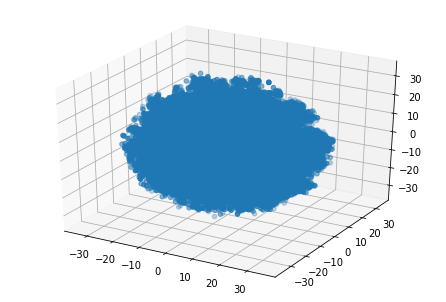

In [41]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
x, y, z = a[:,0], a[:,1], a[:,2]
ax.scatter(x, y, z, alpha=0.3)
plt.show()

In [38]:
a

array([[-13.065912  ,  -7.6421742 ,  23.487041  ],
       [-11.2515    , -18.150614  , -17.608335  ],
       [ -3.733428  ,   0.22281735,  20.17637   ],
       ...,
       [-22.123327  ,   5.2574162 ,   0.12892546],
       [  9.628386  ,  -7.53167   ,  11.480138  ],
       [-24.707315  ,   2.227743  ,  13.986798  ]], dtype=float32)

array([-13.065912 ,  -7.6421742,  23.487041 ], dtype=float32)

In [4]:
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering

from sklearn import metrics  # metrics.calinski_harabasz_score(X, labels)
from sklearn.metrics import davies_bouldin_score,silhouette_score,silhouette_samples

In [50]:
# KMeans 
def call_KMeans(num,emb):
    kmeans_clustering = KMeans(n_clusters=num, random_state=0)
    kmeans_clustering.fit(emb)
    return kmeans_clustering

rel_KMeans = []
print('Start to train')
for i in tqdm([3,5,7,10]):
    diff_emb = []
    for j in [title_distilbert,title_tfidf_w2v,title_w2v]:
        diff_emb.append(call_KMeans(i,j))
    rel_KMeans.append(diff_emb)
print('Done')

Start to train


100%|███████████████████████████████████████████| 4/4 [12:50<00:00, 190.52s/it]


Done


In [5]:
kmeans_clustering_label = KMeans(n_clusters=7, random_state=0).fit_predict(title_distilbert)


In [19]:
class1 = merged_df.loc[np.array(np.where(kmeans_clustering_label == 0))[0]]
class2 = merged_df.loc[np.array(np.where(kmeans_clustering_label == 1))[0]]
class3 = merged_df.loc[np.array(np.where(kmeans_clustering_label == 2))[0]]
class4 = merged_df.loc[np.array(np.where(kmeans_clustering_label == 3))[0]]
class5 = merged_df.loc[np.array(np.where(kmeans_clustering_label == 4))[0]]
class6 = merged_df.loc[np.array(np.where(kmeans_clustering_label == 5))[0]]
class7 = merged_df.loc[np.array(np.where(kmeans_clustering_label == 6))[0]]


class1.to_excel('./class/class1.xlsx')
class2.to_excel('./class/class2.xlsx')
class3.to_excel('./class/class3.xlsx')
class4.to_excel('./class/class4.xlsx')
class5.to_excel('./class/class5.xlsx')
class6.to_excel('./class/class6.xlsx')
class7.to_excel('./class/class7.xlsx')

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,max_features=1500)
tf = tf_vectorizer.fit_transform(class1['preprocessed_title'])
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=20,  # 文章表示成20维的向量
                                max_iter=200,
                                learning_method='batch',
                                verbose=True)
lda.fit(tf) 
print(lda.perplexity(tf)) 
# 收敛效果

iteration: 1 of max_iter: 200
iteration: 2 of max_iter: 200
iteration: 3 of max_iter: 200
iteration: 4 of max_iter: 200
iteration: 5 of max_iter: 200
iteration: 6 of max_iter: 200
iteration: 7 of max_iter: 200
iteration: 8 of max_iter: 200
iteration: 9 of max_iter: 200
iteration: 10 of max_iter: 200
iteration: 11 of max_iter: 200
iteration: 12 of max_iter: 200
iteration: 13 of max_iter: 200
iteration: 14 of max_iter: 200
iteration: 15 of max_iter: 200
iteration: 16 of max_iter: 200
iteration: 17 of max_iter: 200
iteration: 18 of max_iter: 200
iteration: 19 of max_iter: 200
iteration: 20 of max_iter: 200
iteration: 21 of max_iter: 200
iteration: 22 of max_iter: 200
iteration: 23 of max_iter: 200
iteration: 24 of max_iter: 200
iteration: 25 of max_iter: 200
iteration: 26 of max_iter: 200
iteration: 27 of max_iter: 200
iteration: 28 of max_iter: 200
iteration: 29 of max_iter: 200
iteration: 30 of max_iter: 200
iteration: 31 of max_iter: 200
iteration: 32 of max_iter: 200
iteration: 33 of 

In [21]:
def print_top_words(model, feature_names, n_top_words):
    # 打印每个主题下权重较高的term
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
    # 打印主题-词语分布矩阵
    #print(model.components_)


n_top_words = 20
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Topic #0:
authentication files signed self two internal metasploit create apps environment cert multi phishing certificates factor certs require methods protected put
Topic #1:
server client tls side ssl certificate authentication protocol verify messages handshake using oauth2 aes cipher encryption possible connection version communication
Topic #2:
ip address dns find addresses using router mac block tor isp vpn could website behind real get even know via
Topic #3:
file website security shared credentials risks verification external upload using hosting overflow folder text buffer program memory links xml users
Topic #4:
use vpn proxy internet wifi connection see network traffic using home access connected packets browsing company logs computer possible monitor
Topic #5:
page testing hash encrypt security test digital run tcp time login implications gpg files penetration write read allowing webpage signatures
Topic #6:
key public private ssh keys service party third pgp authenticate 

In [22]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,max_features=1500)
tf = tf_vectorizer.fit_transform(class2['preprocessed_title'])
lda = LatentDirichletAllocation(n_components=20,  # 文章表示成20维的向量
                                max_iter=200,
                                learning_method='batch',
                                verbose=True)
lda.fit(tf) 
print(lda.perplexity(tf)) 

def print_top_words(model, feature_names, n_top_words):
    # 打印每个主题下权重较高的term
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
    # 打印主题-词语分布矩阵
    #print(model.components_)


n_top_words = 20
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

iteration: 1 of max_iter: 200
iteration: 2 of max_iter: 200
iteration: 3 of max_iter: 200
iteration: 4 of max_iter: 200
iteration: 5 of max_iter: 200
iteration: 6 of max_iter: 200
iteration: 7 of max_iter: 200
iteration: 8 of max_iter: 200
iteration: 9 of max_iter: 200
iteration: 10 of max_iter: 200
iteration: 11 of max_iter: 200
iteration: 12 of max_iter: 200
iteration: 13 of max_iter: 200
iteration: 14 of max_iter: 200
iteration: 15 of max_iter: 200
iteration: 16 of max_iter: 200
iteration: 17 of max_iter: 200
iteration: 18 of max_iter: 200
iteration: 19 of max_iter: 200
iteration: 20 of max_iter: 200
iteration: 21 of max_iter: 200
iteration: 22 of max_iter: 200
iteration: 23 of max_iter: 200
iteration: 24 of max_iter: 200
iteration: 25 of max_iter: 200
iteration: 26 of max_iter: 200
iteration: 27 of max_iter: 200
iteration: 28 of max_iter: 200
iteration: 29 of max_iter: 200
iteration: 30 of max_iter: 200
iteration: 31 of max_iter: 200
iteration: 32 of max_iter: 200
iteration: 33 of 

In [23]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,max_features=1500)
tf = tf_vectorizer.fit_transform(class3['preprocessed_title'])
lda = LatentDirichletAllocation(n_components=20,  # 文章表示成20维的向量
                                max_iter=200,
                                learning_method='batch',
                                verbose=True)
lda.fit(tf) 
print(lda.perplexity(tf)) 

def print_top_words(model, feature_names, n_top_words):
    # 打印每个主题下权重较高的term
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
    # 打印主题-词语分布矩阵
    #print(model.components_)


n_top_words = 20
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

iteration: 1 of max_iter: 200
iteration: 2 of max_iter: 200
iteration: 3 of max_iter: 200
iteration: 4 of max_iter: 200
iteration: 5 of max_iter: 200
iteration: 6 of max_iter: 200
iteration: 7 of max_iter: 200
iteration: 8 of max_iter: 200
iteration: 9 of max_iter: 200
iteration: 10 of max_iter: 200
iteration: 11 of max_iter: 200
iteration: 12 of max_iter: 200
iteration: 13 of max_iter: 200
iteration: 14 of max_iter: 200
iteration: 15 of max_iter: 200
iteration: 16 of max_iter: 200
iteration: 17 of max_iter: 200
iteration: 18 of max_iter: 200
iteration: 19 of max_iter: 200
iteration: 20 of max_iter: 200
iteration: 21 of max_iter: 200
iteration: 22 of max_iter: 200
iteration: 23 of max_iter: 200
iteration: 24 of max_iter: 200
iteration: 25 of max_iter: 200
iteration: 26 of max_iter: 200
iteration: 27 of max_iter: 200
iteration: 28 of max_iter: 200
iteration: 29 of max_iter: 200
iteration: 30 of max_iter: 200
iteration: 31 of max_iter: 200
iteration: 32 of max_iter: 200
iteration: 33 of 

In [24]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,max_features=1500)
tf = tf_vectorizer.fit_transform(class4['preprocessed_title'])
lda = LatentDirichletAllocation(n_components=20,  # 文章表示成20维的向量
                                max_iter=200,
                                learning_method='batch',
                                verbose=True)
lda.fit(tf) 
print(lda.perplexity(tf)) 

def print_top_words(model, feature_names, n_top_words):
    # 打印每个主题下权重较高的term
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
    # 打印主题-词语分布矩阵
    #print(model.components_)


n_top_words = 20
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

iteration: 1 of max_iter: 200
iteration: 2 of max_iter: 200
iteration: 3 of max_iter: 200
iteration: 4 of max_iter: 200
iteration: 5 of max_iter: 200
iteration: 6 of max_iter: 200
iteration: 7 of max_iter: 200
iteration: 8 of max_iter: 200
iteration: 9 of max_iter: 200
iteration: 10 of max_iter: 200
iteration: 11 of max_iter: 200
iteration: 12 of max_iter: 200
iteration: 13 of max_iter: 200
iteration: 14 of max_iter: 200
iteration: 15 of max_iter: 200
iteration: 16 of max_iter: 200
iteration: 17 of max_iter: 200
iteration: 18 of max_iter: 200
iteration: 19 of max_iter: 200
iteration: 20 of max_iter: 200
iteration: 21 of max_iter: 200
iteration: 22 of max_iter: 200
iteration: 23 of max_iter: 200
iteration: 24 of max_iter: 200
iteration: 25 of max_iter: 200
iteration: 26 of max_iter: 200
iteration: 27 of max_iter: 200
iteration: 28 of max_iter: 200
iteration: 29 of max_iter: 200
iteration: 30 of max_iter: 200
iteration: 31 of max_iter: 200
iteration: 32 of max_iter: 200
iteration: 33 of 

In [25]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,max_features=1500)
tf = tf_vectorizer.fit_transform(class5['preprocessed_title'])
lda = LatentDirichletAllocation(n_components=20,  # 文章表示成20维的向量
                                max_iter=200,
                                learning_method='batch',
                                verbose=True)
lda.fit(tf) 
print(lda.perplexity(tf)) 

def print_top_words(model, feature_names, n_top_words):
    # 打印每个主题下权重较高的term
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
    # 打印主题-词语分布矩阵
    #print(model.components_)


n_top_words = 20
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

iteration: 1 of max_iter: 200
iteration: 2 of max_iter: 200
iteration: 3 of max_iter: 200
iteration: 4 of max_iter: 200
iteration: 5 of max_iter: 200
iteration: 6 of max_iter: 200
iteration: 7 of max_iter: 200
iteration: 8 of max_iter: 200
iteration: 9 of max_iter: 200
iteration: 10 of max_iter: 200
iteration: 11 of max_iter: 200
iteration: 12 of max_iter: 200
iteration: 13 of max_iter: 200
iteration: 14 of max_iter: 200
iteration: 15 of max_iter: 200
iteration: 16 of max_iter: 200
iteration: 17 of max_iter: 200
iteration: 18 of max_iter: 200
iteration: 19 of max_iter: 200
iteration: 20 of max_iter: 200
iteration: 21 of max_iter: 200
iteration: 22 of max_iter: 200
iteration: 23 of max_iter: 200
iteration: 24 of max_iter: 200
iteration: 25 of max_iter: 200
iteration: 26 of max_iter: 200
iteration: 27 of max_iter: 200
iteration: 28 of max_iter: 200
iteration: 29 of max_iter: 200
iteration: 30 of max_iter: 200
iteration: 31 of max_iter: 200
iteration: 32 of max_iter: 200
iteration: 33 of 

In [28]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,max_features=1500)
tf = tf_vectorizer.fit_transform(class6['preprocessed_title'])
lda = LatentDirichletAllocation(n_components=20,  # 文章表示成20维的向量
                                max_iter=200,
                                learning_method='batch',
                                verbose=True)
lda.fit(tf) 
print(lda.perplexity(tf)) 

def print_top_words(model, feature_names, n_top_words):
    # 打印每个主题下权重较高的term
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
    # 打印主题-词语分布矩阵
    #print(model.components_)


n_top_words = 20
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

iteration: 1 of max_iter: 200
iteration: 2 of max_iter: 200
iteration: 3 of max_iter: 200
iteration: 4 of max_iter: 200
iteration: 5 of max_iter: 200
iteration: 6 of max_iter: 200
iteration: 7 of max_iter: 200
iteration: 8 of max_iter: 200
iteration: 9 of max_iter: 200
iteration: 10 of max_iter: 200
iteration: 11 of max_iter: 200
iteration: 12 of max_iter: 200
iteration: 13 of max_iter: 200
iteration: 14 of max_iter: 200
iteration: 15 of max_iter: 200
iteration: 16 of max_iter: 200
iteration: 17 of max_iter: 200
iteration: 18 of max_iter: 200
iteration: 19 of max_iter: 200
iteration: 20 of max_iter: 200
iteration: 21 of max_iter: 200
iteration: 22 of max_iter: 200
iteration: 23 of max_iter: 200
iteration: 24 of max_iter: 200
iteration: 25 of max_iter: 200
iteration: 26 of max_iter: 200
iteration: 27 of max_iter: 200
iteration: 28 of max_iter: 200
iteration: 29 of max_iter: 200
iteration: 30 of max_iter: 200
iteration: 31 of max_iter: 200
iteration: 32 of max_iter: 200
iteration: 33 of 

In [27]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,max_features=1500)
tf = tf_vectorizer.fit_transform(class7['preprocessed_title'])
lda = LatentDirichletAllocation(n_components=20,  # 文章表示成20维的向量
                                max_iter=200,
                                learning_method='batch',
                                verbose=True)
lda.fit(tf) 
print(lda.perplexity(tf)) 

def print_top_words(model, feature_names, n_top_words):
    # 打印每个主题下权重较高的term
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
    # 打印主题-词语分布矩阵
    #print(model.components_)


n_top_words = 20
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

iteration: 1 of max_iter: 200
iteration: 2 of max_iter: 200
iteration: 3 of max_iter: 200
iteration: 4 of max_iter: 200
iteration: 5 of max_iter: 200
iteration: 6 of max_iter: 200
iteration: 7 of max_iter: 200
iteration: 8 of max_iter: 200
iteration: 9 of max_iter: 200
iteration: 10 of max_iter: 200
iteration: 11 of max_iter: 200
iteration: 12 of max_iter: 200
iteration: 13 of max_iter: 200
iteration: 14 of max_iter: 200
iteration: 15 of max_iter: 200
iteration: 16 of max_iter: 200
iteration: 17 of max_iter: 200
iteration: 18 of max_iter: 200
iteration: 19 of max_iter: 200
iteration: 20 of max_iter: 200
iteration: 21 of max_iter: 200
iteration: 22 of max_iter: 200
iteration: 23 of max_iter: 200
iteration: 24 of max_iter: 200
iteration: 25 of max_iter: 200
iteration: 26 of max_iter: 200
iteration: 27 of max_iter: 200
iteration: 28 of max_iter: 200
iteration: 29 of max_iter: 200
iteration: 30 of max_iter: 200
iteration: 31 of max_iter: 200
iteration: 32 of max_iter: 200
iteration: 33 of 

In [15]:
kmeans_clustering_label[:10]

array([1, 5, 1, 1, 0, 1, 0, 5, 0, 6])

In [51]:
# Birch
def call_Birch(num,emb):
    birch_clustering = Birch(n_clusters=num)
    birch_clustering.fit(emb)
    return birch_clustering

rel_Birch = []
print('Start to train')
for i in tqdm([3,5,7,10]):
    diff_emb = []
    for j in [title_distilbert,title_tfidf_w2v,title_w2v]:
        diff_emb.append(call_Birch(i,j))
    rel_Birch.append(diff_emb)
print('Done')
    

Start to train


  0%|                                                    | 0/4 [00:00<?, ?it/s]

MemoryError: unable to allocate array data.

In [52]:
# DBScan
def call_DBScan(emb,myeps = 3):
    dbscan_clustering = DBSCAN(eps=myeps)
    dbscan_clustering.fit(emb)
    return dbscan_clustering

rel_DBScan = []
print('Start to train')
for i in tqdm([3,5,7,10]):
    diff_emb = []
    for j in [title_distilbert,title_tfidf_w2v,title_w2v]:
        diff_emb.append(call_DBScan(j, i))
    rel_DBScan.append(diff_emb)
print('Done')


SyntaxError: non-default argument follows default argument (<ipython-input-52-323d1f5509ce>, line 2)

In [53]:
# SpectralClustering
def call_Spectral(num,emb):
    sp_clustering = SpectralClustering(n_clusters=7,assign_labels="discretize",random_state=0)
    sp_clustering.fit(emb)
    return sp_clustering

rel_Spectral = []
print('Start to train')
for i in tqdm([3,5,7,10]):
    diff_emb = []
    for j in [title_distilbert,title_tfidf_w2v,title_w2v]:
        diff_emb.append(call_Spectral(i,j))
    rel_Spectral.append(diff_emb)
print('Done')

Start to train



  0%|                                                    | 0/4 [00:00<?, ?it/s]

MemoryError: 

In [45]:
#Splitting x and y into 2 parts(train(85%) and test(15%))
#x: title
#y: topic
x, y = merged_df['preprocessed_title'].values, merged_df['Topic'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.15, stratify = y)

In [69]:
def ml_model(model):
      '''
      This function accepts the name of the ML model and returns object of
      respected trained ML model.
      Possible ML model names are: NaiveBayes, LogisticRegression and SVC.
      '''

    start_time = time.time()
    if model == 'NaiveBayes':
    #Naive Bayes
        classifier = Pipeline([('vect', CountVectorizer()),
                               ('tfidf', TfidfTransformer()),
                               ('clf', MultinomialNB()),
                              ])
        classifier.fit(x_train, y_train)
        y_pred = classifier.predict(x_test)

    elif model == 'LogisticRegression':
        #Logistic Regression
        classifier = Pipeline([('vect', CountVectorizer()),
                  ('tfidf', TfidfTransformer()),
                 ('clf', LogisticRegression(n_jobs=-1, C=1e6)),
                 ])
        classifier.fit(x_train, y_train)
        y_pred = classifier.predict(x_test)

    elif model == 'SVC':
    #SVC
        classifier = Pipeline([('vect', CountVectorizer()),
                  ('tfidf', TfidfTransformer()),
                  ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-5, random_state=42, max_iter=5, tol=None, n_jobs=-1)),
                 ])
        classifier.fit(x_train, y_train)
        y_pred = classifier.predict(x_test)

    print(model,'model has been trained in',np.round(time.time() - start_time,2),'seconds.')
    print('\nClassification Report:\n')
    print(classification_report(y_test, y_pred,target_names=merged_df['Topic'].unique()))

    return classifier

In [70]:
model_names = ['NaiveBayes', 'LogisticRegression', 'SVC']
model_obj = dict()

for i in range(len(model_names)):
    print('-'*75)
    model = ml_model(model_names[i])
    model_obj[model_names[i]] = model 
    print('-'*75)

---------------------------------------------------------------------------
NaiveBayes model has been trained in 11.49 seconds.

Classification Report:

              precision    recall  f1-score   support

    Security       1.00      1.00      1.00      8530

   micro avg       1.00      1.00      1.00      8530
   macro avg       1.00      1.00      1.00      8530
weighted avg       1.00      1.00      1.00      8530

---------------------------------------------------------------------------
---------------------------------------------------------------------------


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 'Security'

In [71]:
#Saving topic prediction models
joblib.dump(model_obj,'save/model_obj.pkl')

['save/model_obj.pkl']

In [21]:
if os.path.exists('save/model_obj.pkl'):
    #Loading topic prediction models
    model_obj = joblib.load('save/model_obj.pkl')
    print('Topic prediction model has been loaded.')
else:
    print('No model has been found!!!\nTrain your topic prediction model again.')

Topic prediction model has been loaded.


In [26]:
#Random sanity check of topic prediction model
model_names = ['NaiveBayes', 'LogisticRegression', 'SVC']
for index in range(3):
    print(model_names[index])
    print('-'*50)
    for i in range(5):
        n = random.randint(0,merged_df.shape[0])
        print(i+1,'] Predicted topic:',model_obj[model_names[index]].predict([merged_df.preprocessed_title[n]])[0])
        print('Actual topic:',merged_df.Topic[n],'\n')
    print('-'*50)

NaiveBayes
--------------------------------------------------
1 ] Predicted topic: android
Actual topic: android 

2 ] Predicted topic: webapps
Actual topic: webapps 

3 ] Predicted topic: android
Actual topic: android 

4 ] Predicted topic: android
Actual topic: android 

5 ] Predicted topic: webapps
Actual topic: webapps 

--------------------------------------------------
LogisticRegression
--------------------------------------------------
1 ] Predicted topic: softwareengineering
Actual topic: softwareengineering 

2 ] Predicted topic: android
Actual topic: android 

3 ] Predicted topic: softwareengineering
Actual topic: softwareengineering 

4 ] Predicted topic: softwareengineering
Actual topic: softwareengineering 

5 ] Predicted topic: cs
Actual topic: ai 

--------------------------------------------------
SVC
--------------------------------------------------
1 ] Predicted topic: datascience
Actual topic: datascience 

2 ] Predicted topic: softwareengineering
Actual topic: sof

In [62]:
#Building text corpus of titles for spell correction

if os.path.exists('save/corpus_word_dict.pkl'):
    #Loading corpus dictionary
    corpus_word_dict = joblib.load('save/corpus_word_dict.pkl')
    print('Spell corrector dictionary has been loaded.')
else:
    #Taking preprocessed title without removing stop words.
    preprocessed_title = []
    title = list(merged_df['Title'].values)
    for i in title:
        preprocessed_title.append(decontraction(remove_punctuation(remove_url(remove_html(i)))))
    corpus = ''
    for i in preprocessed_title:
        corpus += i
    corpus = re.sub("\d+", " ", corpus)
    #Getting count of each words in dictionary
    corpus_word_dict = Counter(corpus.split())
    #Saving corpus dictionary
    joblib.dump(corpus_word_dict,'save/corpus_word_dict.pkl')
    print('Spell corrector dictionary has been saved.')

Spell corrector dictionary has been saved.


In [63]:
#Ref: https://norvig.com/spell-correct.html

#Few functions to correct the spelling of given word.

def Probability(word, N = sum(corpus_word_dict.values())): 
    """
    This function finds probability of word.
    """
    return corpus_word_dict[word] / N

def correction(word): 
    """
    This function finds most probable spelling correction for word.
    """
    return max(candidates(word), key = Probability)

def candidates(word): 
    """
    This function generates possible spelling corrections for word.
    """
    return (known_word([word]) or known_word(word_away_1(word)) or known_word(word_away_2(word)) or [word])

def known_word(words): 
    """
    The subset of words that appear in the dictionary of WORDS.
    """
    return set(w for w in words if w in corpus_word_dict)

def word_away_1(word):
    """
    This function finds words that are one char away from input word.
    """
    alphabets = 'abcdefghijklmnopqrstuvwxyz'
    splits = [(word[:i], word[i:]) for i in range(len(word) + 1)]
    deletes = [left + right[1:] for left, right in splits if right]
    transposes = [left + right[1] + right[0] + right[2:] for left, right in splits if len(right) > 1]
    replaces = [left + center + right[1:] for left, right in splits if right for center in alphabets]
    inserts = [left + center + right for left, right in splits for center in alphabets]
    return set(deletes + transposes + replaces + inserts)

def word_away_2(word): 
    """
    This function finds words that are two char away from input word.
    """
    return (e2 for e1 in word_away_1(word) for e2 in word_away_1(e1))

In [55]:
#Few utility functions for search engine optimization and evaluation.

'''
As we are building search engines so low latency is one of the most important constraints that needs to be considered.

So to make this search engine more faster, searching the recommended question only through those questions
which belong to the same category of input searched question.

E.g. For questions belonging to ai, it is more likely to find a similar question from ai category only.

Thus, it reduces the time by avoiding searching through all questions.

The below function creates dictionary which contains all topic names as key and their respective indices list as value.
'''
#Getting indices for feature by topic to reduce the search time through all data points as related questions are more likely to be of same topic.
def filter_topic_wise_data(topic):
    '''
    This function accepts the topic name and returns all indices of datapoint for that topic.
    '''
    filter_indices = []
    for i in range(merged_df.shape[0]):
        if merged_df['Topic'].values[i] == topic:
            filter_indices.append(i)
    return filter_indices

if os.path.exists('save/topic_index_dict.pkl'):
    #Loading dictionary
    topic_index_dict = joblib.load('save/topic_index_dict.pkl')
else:
    #Getting all unique topics
    topics = merged_df['Topic'].unique()
    #Storing indices of all datapoints for each unique topic
    topic_index_dict = {}
    for topic in topics:
        topic_index_dict[topic] = filter_topic_wise_data(topic)
    #Saving dictionary
    joblib.dump(topic_index_dict,'save/topic_index_dict.pkl')


'''
As we are building search engines so low latency is one of the most important constraints that needs to be considered.

So to make this search engine more faster, searching the recommended question only through those questions
which has same tag as of input searched question.

Thus, it reduces the time by avoiding searching through all questions.

The below function creates dictionary which contains all tag names as key and their respective indices list as value.
'''
#Getting indices for feature by tags to reduce the search time through all data points as related questions are more likely to have same tag.
def filter_tag_wise_data(tag):
    '''
    This function accepts the tag of the question and returns all indices of datapoint for that tag.
    '''
    filter_indices = []
    for i in range(merged_df.shape[0]):
        if tag in merged_df['preprocessed_tags'].values[i]:
            filter_indices.append(i)
    return filter_indices

if os.path.exists('save/tag_index_dict.pkl'):
    #Loading dictionary
    tag_index_dict = joblib.load('save/tag_index_dict.pkl')
else:
    #Getting all unique tags
    all_tag_list = []
    for i in merged_df['preprocessed_tags'].values:
        all_tag_list.extend(i.split())
    all_tag_list = list(set(all_tag_list))
    #Storing indices of all datapoints with each unique tag
    tag_index_dict = {}
    for tag in all_tag_list:
        tag_index_dict[tag] = filter_tag_wise_data(tag)
    #Saving dictionary
    joblib.dump(tag_index_dict,'save/tag_index_dict.pkl')



#Utility functions for search engine.
def get_vector(vectorizer, preprocessed_user_input):
    '''
    This function accepts the vectorizer and preprocess user input and return embedded vector as per passed vectorizer
    '''
    if vectorizer == 'TF-IDF':
        return title_tfidf_vectorizer.transform([preprocessed_user_input])

    elif vectorizer == 'TF-IDF Word2Vec':
        return funct_tfidf_w2v(preprocessed_user_input)
    
    elif vectorizer == 'Word2Vec':
        return word_to_vector(preprocessed_user_input, title_w2v_model)

    elif vectorizer == 'distilBERT':
        return distilbert_embedding(preprocessed_user_input)
    
    elif vectorizer == 'Universal Sentence Encoder':
        return universal_sentence_encoding([preprocessed_user_input])



#Utility functions for evaluating search engine result.
def get_word_vector(title, vectorizer):
    '''
    This function accepts the title of question and vectorizer name and returns embedded vector of title for each word.
    '''
    vec = []
    for i in title.split():
        if vectorizer == 'TF-IDF':
            if i in title_tfidf_vectorizer.vocabulary_:
                vec.append(title_tfidf_vectorizer.vocabulary_[i])
            else:
                vec.append(np.zeros(shape=(6073,)))

        elif vectorizer == 'TF-IDF Word2Vec':
            if i in glove_words:
                vec.append(glove_vectors_model[i])
            else:
                vec.append(np.zeros(shape=(300,)))

        elif vectorizer == 'Word2Vec':
            if i in set(title_w2v_model.wv.vocab.keys()):
                vec.append(title_w2v_model[i])
            else:
                vec.append(np.zeros(shape=(300,)))

        elif vectorizer == 'distilBERT':
            for i in title.split():
                vec.append(np.zeros(shape=(768,)))

        elif vectorizer == 'Universal Sentence Encoder':
            for i in title.split():
                vec.append(np.zeros(shape=(512,)))

    return np.array(vec)

def get_distance(vec1, vec2):
    '''
    This function is to calculates distance between vectors
    '''
    final_dist = []
    for i in vec1:
        dist = []
        for j in vec2:
            dist.append(np.linalg.norm(i-j))
        final_dist.append(np.array(dist))
    return np.array(final_dist)

def heatmap(input_title, predicted_title, vectorizer):
    '''
    This function accepts the input_title, predicted_title and name of used vectorizer,
    and plots the heatmap between input and predicted title.
    '''
    s1_vec = get_word_vector(input_title, vectorizer)
    s2_vec = get_word_vector(predicted_title, vectorizer)
    s1_s2_dist = get_distance(s1_vec, s2_vec)

    plt.figure(figsize=(10,10))

    # ploting the heap map based on the pairwise distances
    ax = sns.heatmap(np.round(s1_s2_dist,6), annot=False)
    # set the x axis labels as recommended apparels title
    ax.set_xticklabels(predicted_title.split())
    # set the y axis labels as input apparels title
    ax.set_yticklabels(input_title.split())

    plt.show()

In [90]:
def StackOverflow(vectorizer, search_option, num_results, title_weight = 20, text_weight = 10, tag_weight = 10):
  
    '''
    This function returns the relate question given user query search question.

    Input Parameters:
    vectorizer: this paramater is to specify which vectorizer to use for text embedding.
    search_option: search either using query text or question id.
    num_results: number of results to be displayed.
    title_weight: weight of the title feature by default it's value is 20.
    text_weight: weight of the text feature by default it's value is 10.
    tag_weight: weight of the tag feature by default it's value is 10.
    
    Note: By default features text and tag has same weight wheras title feature has more weight.
    '''

    preprocessed_title_output = []

    if vectorizer == "TF-IDF":
        title_features = title_tfidf
        text_features = text_tfidf
        tag_features = tag_tfidf

    elif vectorizer == "Word2Vec":
        title_features = title_w2v
        text_features = text_w2v
        tag_features = tag_w2v

    elif vectorizer == "TF-IDF Word2Vec":
        title_features = title_tfidf_w2v
        text_features = text_tfidf_w2v
        tag_features = tag_tfidf_w2v

    elif vectorizer == "distilBERT":
        title_features = title_distilbert
        text_features = text_distilbert
        tag_features = tag_distilbert

    elif vectorizer == "Universal Sentence Encoder":
        title_features = title_universal_sentence_encoder
        text_features = text_universal_sentence_encoder
        tag_features = tag_universal_sentence_encoder

    # output = "<br/><center><img width='90%' style='border-style: solid;border-color: white; border-radius: 10px;' src='https://i.ibb.co/p3PdbQF/stackoverflow-my-logo.jpg'/></center><br/>"
    output = "<br/><center></center><br/>"

    if search_option == 'Text':
        ip = "<h2>Enter query text to search:</h2>"
        display(HTML(ip))
        user_input = input()
        start_time = time.time()
        user_input = str(user_input)
        #Preprocessing user input text
        preprocessed_user_input = decontraction(remove_punctuation(remove_url(remove_html(user_input))))
        #Spell correction of words
        corrected_preprocessed_user_input = ''
        for i in preprocessed_user_input.split():
            corrected_preprocessed_user_input += correction(i) + ' '
        preprocessed_user_input = remove_stopwords(corrected_preprocessed_user_input)
        preprocessed_title_output.append(preprocessed_user_input)
        #Predicting the topic or categpry of user input text using SVC model.
        topic = model_obj['NaiveBayes'].predict([preprocessed_user_input])[0]
        #Getting embedded vector of preprocessed user input as per passed vectorizer
        if vectorizer == "TF-IDF Word2Vec":
            input_embed = get_vector(vectorizer, [preprocessed_user_input])
        else:
            input_embed = get_vector(vectorizer, preprocessed_user_input)
        #pairwise distance between searched question title and all other title
        pairwise_dist = pairwise_distances(title_features[topic_index_dict[topic]],input_embed.reshape(1,-1))
        # np.argsort will return indices of the smallest distances
        indices = np.argsort(pairwise_dist.flatten())[0:num_results]
        #pdists will store the smallest distances
        pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
        # output += '<div style="border: 4px solid silver;border-radius: 4px;background-color:green;width:90%;margin-left:5%;padding:15px;">'
        output += '<h1><u> Questions related to your search </u></h1><h5>About ' + str(num_results) + ' results (' + str(time.time() - start_time) + ' seconds)</h5></div>'
        output += '<div style="border: 4px solid silver;border-radius: 4px;width:90%;margin-left:5%;padding:15px;">'
        output += '<h2> You searched for : <u style="color: #6666ff;">' +str(user_input)+ '</u></h2>'
        output += '<h3> Showing result for : <u style="color: #6666ff;">' +str(corrected_preprocessed_user_input)+ '</u></h3></div>'
        for i in range(0,len(indices)):
            preprocessed_title_output.append(merged_df['preprocessed_title'].values[[topic_index_dict[topic]]][indices[i]])
            #If there is not even one word similarity between input text and predicted text, flag will be set to 0.
            #flag = 0 won't show irrelevant text instead shows message to try different keywords.
            if i == 0:
                flag = 0
                for j in preprocessed_title_output[i].split(): 
                    for k in preprocessed_title_output[i+1].split():
                        if j == k:
                            flag = 1
                            break
                    if flag == 1:
                        break
            if flag == 1: #flag with value 1 defines that there is at least one word similarity between input text and predicted text.
                output += '<div style="border: 4px solid silver;border-radius: 4px;width:90%;margin-left:5%;padding:15px;">'
                #output += '<h4 style="float:right;"> Pairwise distance : ' + str(pdists[i]) + '</h4>'
                output += '<h2>' + str(i+1)+ '] <u style="color: #6666ff;">' +str(merged_df['Title'].values[[topic_index_dict[topic]]][indices[i]])+ '</u></h2>'
                output += '<h3> Tags: ' + re.sub(r'_',r'-', re.sub(r' ',r', ', str(merged_df['preprocessed_tags'].values[[topic_index_dict[topic]]][indices[i]]))) + '</h3>'
                output += '</div>'
            elif flag == 0: #flag with value 0 defines that there is not even single word similarity between input text and predicted text.
                # output = "<br/><center><img width='90%' style='border-style: solid;border-color: white; border-radius: 10px;' src='https://i.ibb.co/p3PdbQF/stackoverflow-my-logo.jpg'/></center><br/>"
                output += '<div style="border: 4px solid silver;border-radius: 4px;background-color:green;width:90%;margin-left:5%;padding:15px;">'
                output += '<h1><u> Questions related to your search </u></h1></div>'
                output += '<div style="border: 4px solid silver;border-radius: 4px;width:90%;margin-left:5%;padding:15px;">'
                output += '<h2><i style="color: #ff0000;">Your search - </i>' +str(user_input)+ '<i style="color: #ff0000;"> - did not matched any StackOverflow question.</i></h2>'
                output += '<h2><u>Suggestions:</u></h2>'
                output += '<h3>&#9900;&nbsp; Make sure that all words are spelled correctly.</h3>'
                output += '<h3>&#9900;&nbsp; Try different keywords.</h3>'
                output += '</div>'
                break 

    elif search_option == 'Id':
        ip = "<h2>Enter question id to search:</h2>"
        display(HTML(ip))
        user_input = input()
        start_time = time.time()
        user_input = int(user_input)
        #Getting indices of question with these input question tags
        tag_index = []
        for i in merged_df['preprocessed_tags'].values[user_input].split():
            tag_index.extend(tag_index_dict[i])
        tag_index = list(set(tag_index))
        #pairwise distance between searched question title and all other title
        title = pairwise_distances(title_features[tag_index],title_features[user_input].reshape(1,-1))
        #pairwise distance between searched question text and all other text  
        text = pairwise_distances(text_features[tag_index],text_features[user_input].reshape(1,-1))
        #pairwise distance between searched question tag and all other tag
        tag = pairwise_distances(tag_features[tag_index],tag_features[user_input].reshape(1,-1))
        #Pairwise distance between query question and all other question w.r.t. all features(title, text and tag)
        pairwise_dist = ((title * title_weight) + (text * text_weight) + (tag * tag_weight)) / float(title_weight + text_weight + tag_weight)
        # np.argsort will return indices of the smallest distances
        indices = np.argsort(pairwise_dist.flatten())[0:num_results+1]
        #pdists will store the smallest distances
        pdists  = np.sort(pairwise_dist.flatten())[0:num_results+1]
        for i in range(0,len(indices)):
            if i == 0:
                preprocessed_title_output.append(merged_df['preprocessed_title'].values[[tag_index]][indices[i]])
                # output += '<div style="border: 4px solid silver;border-radius: 4px;background-color:green;width:90%;margin-left:5%;padding:15px;">'
                output += '<h1><u> Questions related to your search </u></h1><h5>About ' + str(num_results) + ' results (' + str(time.time() - start_time) + ' seconds)</h5></div>'
                output += '<div style="border: 4px solid silver;border-radius: 4px;width:90%;margin-left:5%;padding:15px;">'
                output += '<h2> You searched for : <u style="color: #6666ff;">' +str(merged_df['Title'].values[[tag_index]][indices[i]])+ '</u></h2>'
                output += '<h3> Tags: ' + re.sub(r'_',r'-', re.sub(r' ',r', ', str(merged_df['preprocessed_tags'].values[[tag_index]][indices[i]]))) + '</h3></div>'
                continue
            preprocessed_title_output.append(merged_df['preprocessed_title'].values[[tag_index]][indices[i]])
            output += '<div style="border: 4px solid silver;border-radius: 4px;width:90%;margin-left:5%;padding:15px;">'
            #output += '<h4 style="float:right;"> Pairwise distance : ' + str(pdists[i]) + '</h4>'
            output += '<h2>' + str(i)+ '] <u style="color: #6666ff;">' +str(merged_df['Title'].values[[tag_index]][indices[i]])+ '</u></h2>'
            output += '<h3> Tags: ' + re.sub(r'_',r'-', re.sub(r' ',r', ', str(merged_df['preprocessed_tags'].values[[tag_index]][indices[i]]))) + '</h3>'
            output += '</div>'

    display(HTML(output))

    return preprocessed_title_output

In [73]:
#Displaying option to select search type, text embedding type and number of results to be displayed.

ip1 = "<h2>Select search type:</h2>"
ip2 = "<br/><h2>Select text embedding type:</h2>"
ip3 = "<br/><h2>Select numer of results to be displayed(max 100):</h2>"

#Creating toggle buttons and slider for search option, text embedding and number of results to be displayed.
search_opt = widgets.ToggleButtons(options=['Id','Text'], button_style='success', tooltips=['Search using query text', 'Search using question id'])
text_embedding = widgets.ToggleButtons(options=['TF-IDF','TF-IDF Word2Vec','Word2Vec','distilBERT','Universal Sentence Encoder'], button_style='info')
no_of_result = widgets.IntSlider(value=5, min=0, max=100)

display(HTML(ip1))
display(search_opt)

display(HTML(ip2))
display(text_embedding)

display(HTML(ip3))
display(no_of_result)

ToggleButtons(button_style='success', options=('Id', 'Text'), tooltips=('Search using query text', 'Search usi…

ToggleButtons(button_style='info', options=('TF-IDF', 'TF-IDF Word2Vec', 'Word2Vec', 'distilBERT', 'Universal …

IntSlider(value=5)

In [122]:
# Manually testing search engine results
# Example of user entering invalid/ irrelevant text
op = StackOverflow(vectorizer = text_embedding.value, search_option = search_opt.value, num_results = no_of_result.value)

# How to use DES to encrypt data  What data encryption algorithms are there

# distilBERT

What data encryption algorithms are there


I0925 17:09:45.356731  4584 SentenceTransformer.py:39] Load pretrained SentenceTransformer: distilbert-base-nli-mean-tokens/
I0925 17:09:45.358731  4584 SentenceTransformer.py:43] Did not find folder distilbert-base-nli-mean-tokens/. Assume to download model from server.
I0925 17:09:45.389753  4584 SentenceTransformer.py:93] Load SentenceTransformer from folder: C:\Users\yun/.cache\torch\sentence_transformers\sbert.net_models_distilbert-base-nli-mean-tokens_
I0925 17:09:50.057031  4584 SentenceTransformer.py:117] Use pytorch device: cpu


In [113]:
#Using TF-IDF and text search
optf = StackOverflow(vectorizer = text_embedding.value, search_option = search_opt.value, num_results = no_of_result.value)



63


In [121]:
#Using Word2Vec and text search
opwv = StackOverflow(vectorizer = text_embedding.value, search_option = search_opt.value, num_results = no_of_result.value)



How to use AES to encrypt data


IndexError: too many indices for array

In [116]:
#Using TF-IDF Word2Vec and text search
optfwv = StackOverflow(vectorizer = text_embedding.value, search_option = search_opt.value, num_results = no_of_result.value)



What is cybersecurity


In [108]:
#Using TF-IDF and id search
op = StackOverflow(vectorizer = text_embedding.value, search_option = search_opt.value, num_results = no_of_result.value)

52


In [109]:
#Using universal_sentence_encoder and text search
op = StackOverflow(vectorizer = text_embedding.value, search_option = search_opt.value, num_results = no_of_result.value)

Why should I hash passwords


ValueError: invalid literal for int() with base 10: 'Why should I hash passwords'

In [111]:
def StackOverflow_Evaluate(op, vectorizer):
    '''
    This function evaluates the search engine output by plotting heatmap for each
    word distances between query post title/ query text and predicted title.
    '''
    label = "<h2><u>Heatmap between input and predicted question title :-</u></h2>"
    display(HTML(label))
    for i in range(1,len(op)):
        print('\n\nHeatmap between input title and predicted title',i,'\n')
        heatmap(op[0], op[i], vectorizer)



Heatmap between input title and predicted title 1 



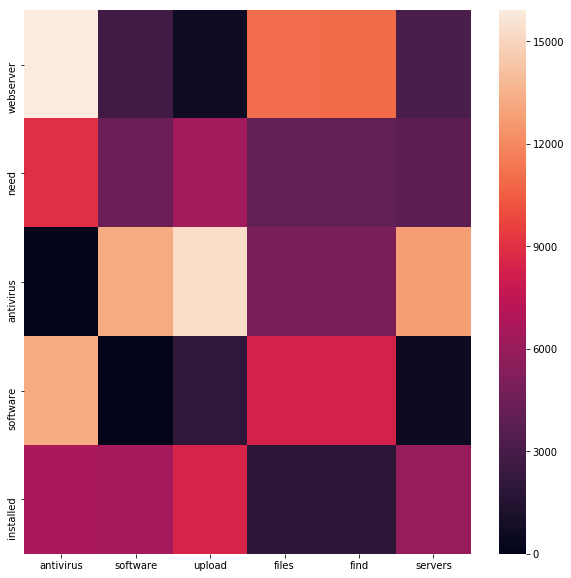



Heatmap between input title and predicted title 2 



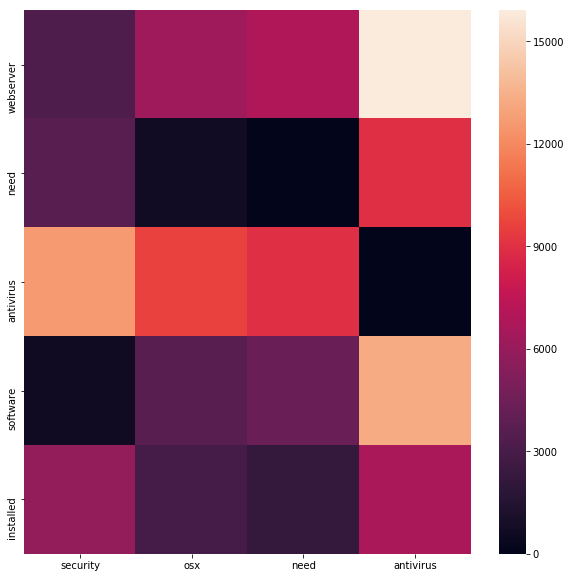



Heatmap between input title and predicted title 3 



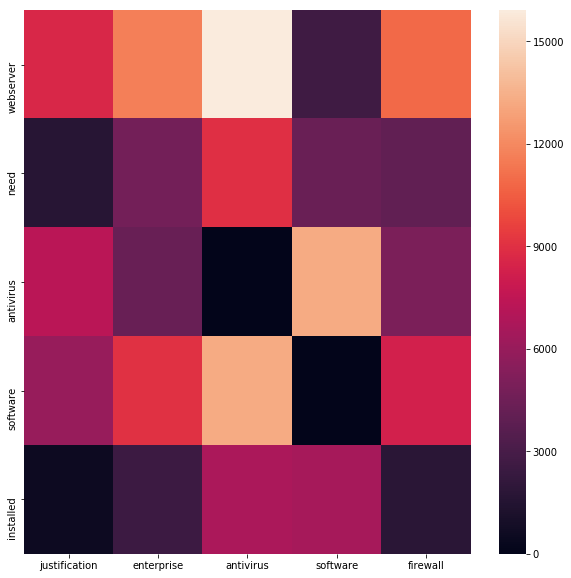



Heatmap between input title and predicted title 4 



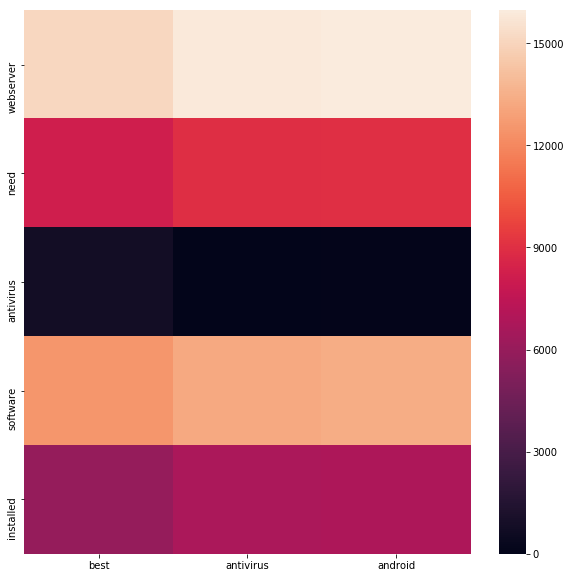



Heatmap between input title and predicted title 5 



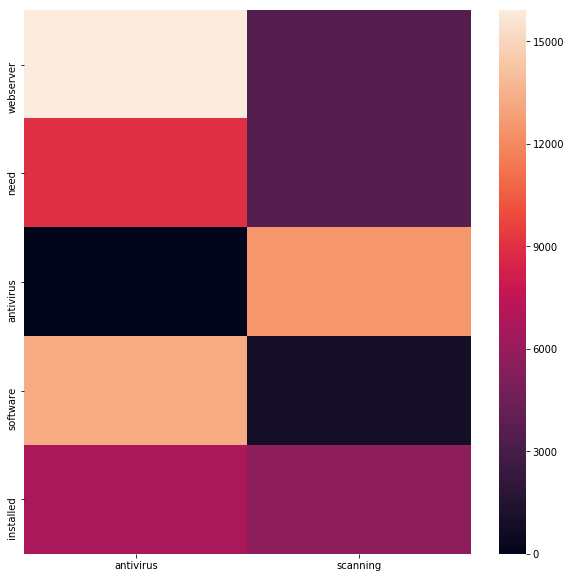



Heatmap between input title and predicted title 6 



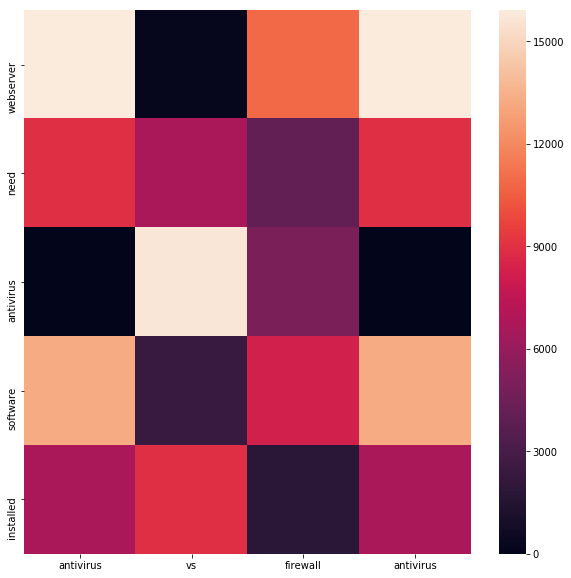

In [114]:
#For TF-IDF id search
StackOverflow_Evaluate(optf, text_embedding.value)



Heatmap between input title and predicted title 1 



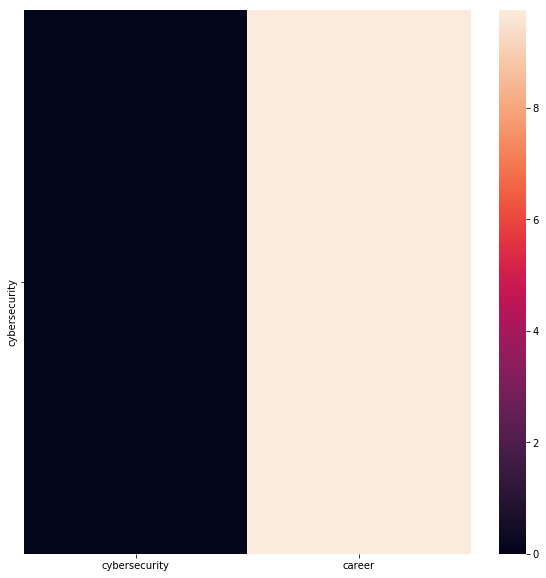



Heatmap between input title and predicted title 2 



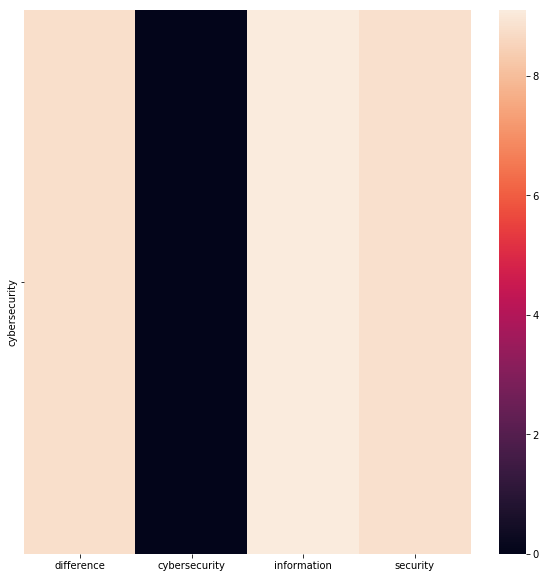



Heatmap between input title and predicted title 3 



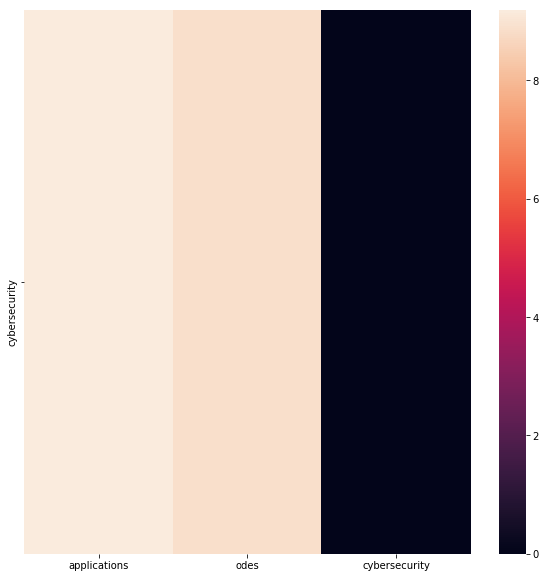



Heatmap between input title and predicted title 4 



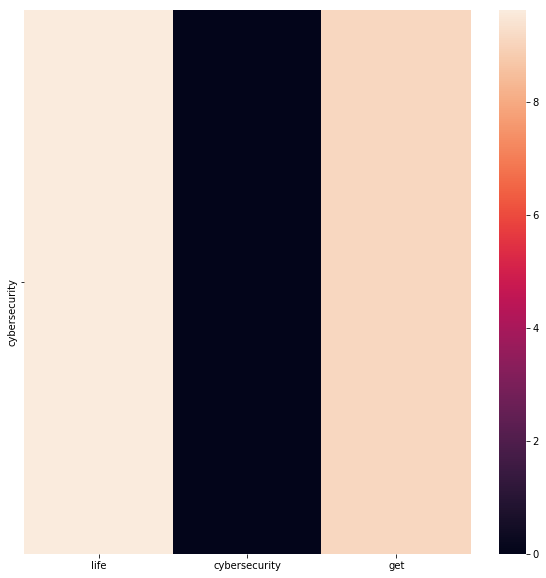



Heatmap between input title and predicted title 5 



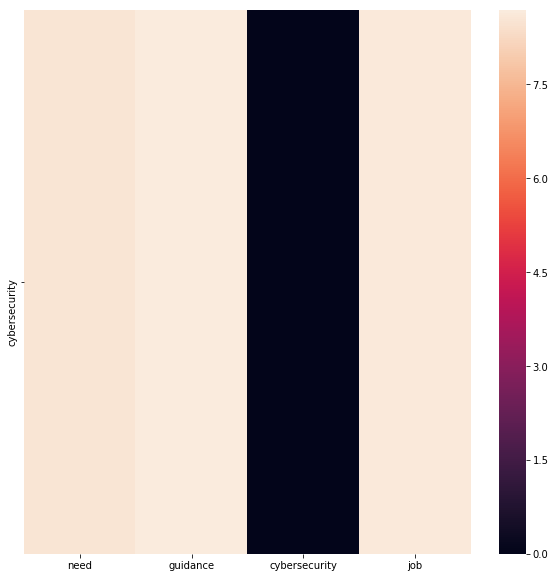



Heatmap between input title and predicted title 6 



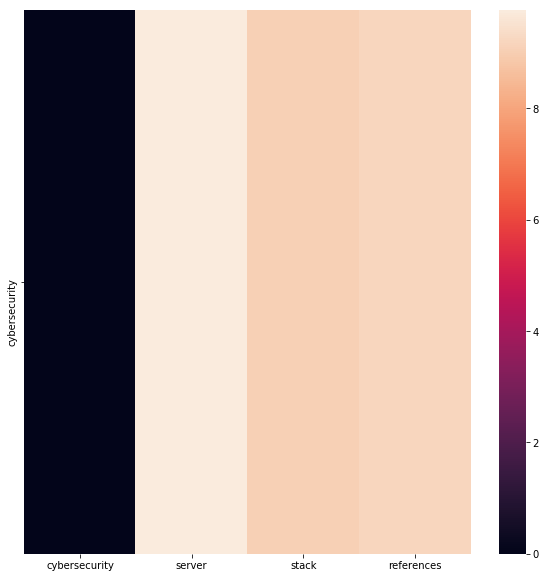

In [117]:
#For TF-IDF Word2Vec id search
StackOverflow_Evaluate(optfwv, text_embedding.value)



Heatmap between input title and predicted title 1 



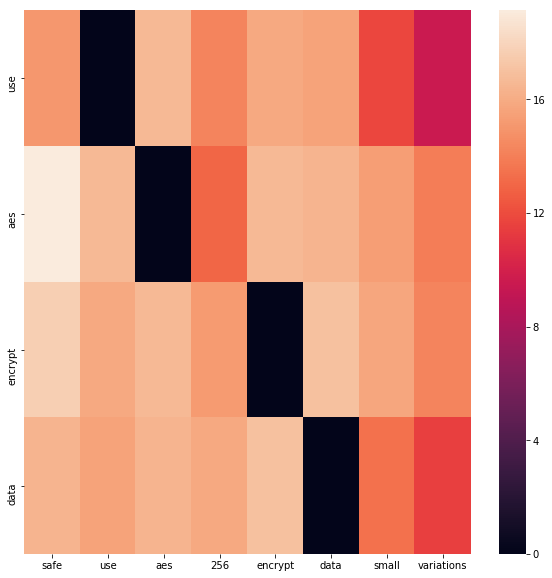



Heatmap between input title and predicted title 2 



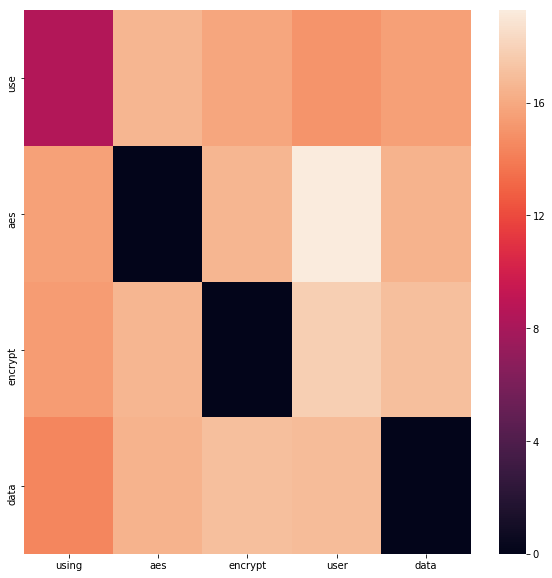



Heatmap between input title and predicted title 3 



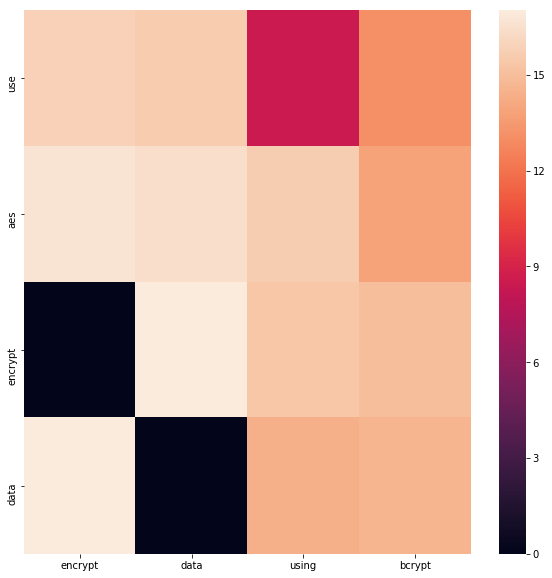



Heatmap between input title and predicted title 4 



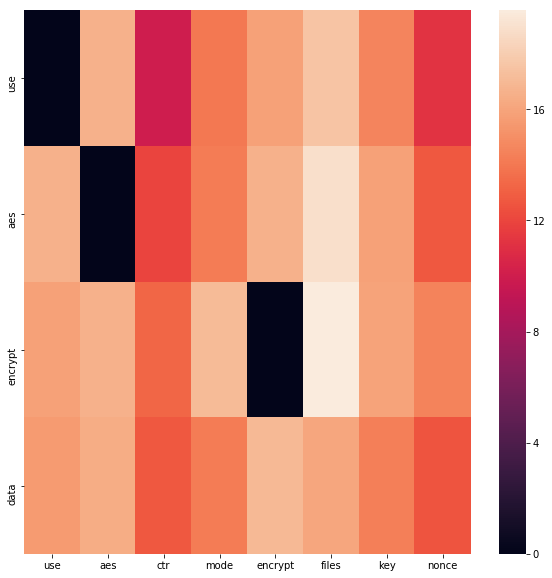



Heatmap between input title and predicted title 5 



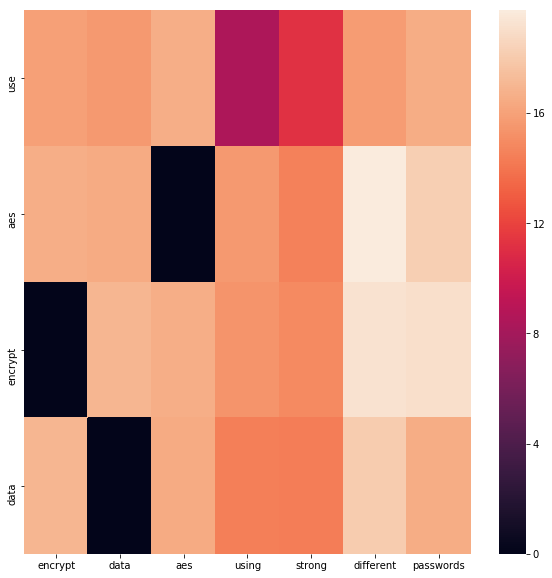



Heatmap between input title and predicted title 6 



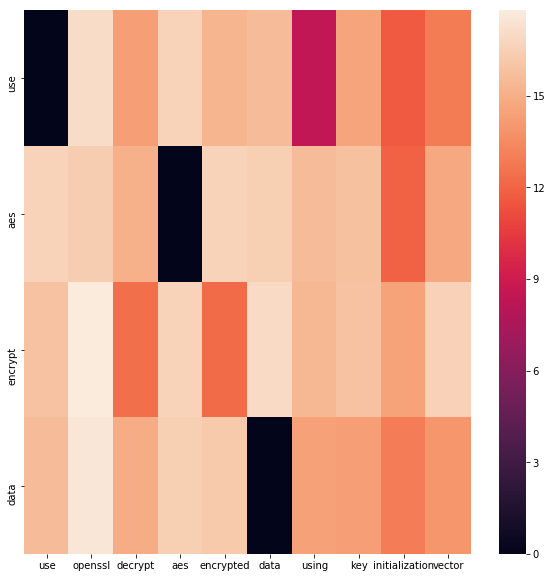

In [120]:
#For Word2Vec text search
StackOverflow_Evaluate(opwv, text_embedding.value)